<a href="https://colab.research.google.com/github/Rohanrathod7/Kaggle_Notebooks/blob/main/Predicting_Loan_Payback/Predicting_Loan_Payback_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import drive

# ====================================================
# Setup & Imports
# ====================================================

import os
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Settings for cleaner output and consistent plotting
warnings.filterwarnings("ignore") # Suppress warnings for cleaner output
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8) # Default figure size for plots

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print("Setup complete: Warnings suppressed, plotting styles set, and reproducibility ensured.")

# --- Data Loading and Initial Inspection ---

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define the file paths, assuming they are in a subfolder like 'Colab Notebooks' within My Drive
train_path = '/content/drive/MyDrive/Predicting Loan Payback/playground-series-s5e11/train.csv'
test_path = '/content/drive/MyDrive/Predicting Loan Payback/playground-series-s5e11/test.csv'

# 3. Load train.csv into a pandas DataFrame named df_train
df_train = pd.read_csv(train_path)

# 4. Load test.csv into a pandas DataFrame named df_test
df_test = pd.read_csv(test_path)


Setup complete: Warnings suppressed, plotting styles set, and reproducibility ensured.
Mounted at /content/drive


In [2]:
def data_info(df, df_name):
    """Comprehensive overview of a DataFrame with styled output."""

    print(f"\n{'='*80}")
    print(f"📊 Comprehensive Information for DataFrame: {df_name}")
    print(f"{'='*80}\n")

    # --- Shape ---
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

    # --- Head ---
    print(f"--- {df_name} Head ---\n")
    display(df.head().style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    # --- Column Summary ---
    print(f"\n--- {df_name} Column Summary ---\n")
    summary = pd.DataFrame({
        "DataType": df.dtypes,
        "Non-Null Count": df.notnull().sum(),
        "Unique Values": df.nunique(),
        "Missing Values": df.isnull().sum(),
        "Missing %": (df.isnull().sum() / len(df)) * 100
    })
    display(summary.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    # --- Describe (numeric only) ---
    if df.select_dtypes(include=np.number).shape[1] > 0:
        print(f"\n--- {df_name} Numeric Summary ---\n")
        display(df.describe().style.set_table_styles([
            {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
            {'selector': 'td', 'props': [('font-size', '10pt')]}
        ], overwrite=False))

    # --- Describe (categorical only) ---
    cat_cols = df.select_dtypes(exclude=np.number).columns
    if len(cat_cols) > 0:
        print(f"\n--- {df_name} Categorical Summary ---\n")
        cat_summary = df[cat_cols].describe().transpose()
        display(cat_summary.style.set_table_styles([
            {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
            {'selector': 'td', 'props': [('font-size', '10pt')]}
        ], overwrite=False))

    print(f"\n{'='*80}\n")

# Apply
data_info(df_train, "df_train")
data_info(df_test, "df_test")


📊 Comprehensive Information for DataFrame: df_train

Shape: 593994 rows × 13 columns

--- df_train Head ---



,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.990000,0.084000,736,2528.420000,13.670000,Female,Single,High School,Self-employed,Other,C3,1.000000
1,1,22108.020000,0.166000,636,4593.100000,12.920000,Male,Married,Master's,Employed,Debt consolidation,D3,0.000000
2,2,49566.200000,0.097000,694,17005.150000,9.760000,Male,Single,High School,Employed,Debt consolidation,C5,1.000000
3,3,46858.250000,0.065000,533,4682.480000,16.100000,Female,Single,High School,Employed,Debt consolidation,F1,1.000000
4,4,25496.700000,0.053000,665,12184.430000,10.210000,Male,Married,High School,Employed,Other,D1,1.000000



--- df_train Column Summary ---



,DataType,Non-Null Count,Unique Values,Missing Values,Missing %
id,int64,593994,593994,0,0.000000
annual_income,float64,593994,119728,0,0.000000
debt_to_income_ratio,float64,593994,526,0,0.000000
credit_score,int64,593994,399,0,0.000000
loan_amount,float64,593994,111570,0,0.000000
interest_rate,float64,593994,1454,0,0.000000
gender,object,593994,3,0,0.000000
marital_status,object,593994,4,0,0.000000
education_level,object,593994,5,0,0.000000
employment_status,object,593994,5,0,0.000000



--- df_train Numeric Summary ---



,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,296996.500000,48212.202976,0.120696,680.916009,15020.297629,12.356345,0.798820
std,171471.442235,26711.942078,0.068573,55.424956,6926.530568,2.008959,0.400883
min,0.000000,6002.430000,0.011000,395.000000,500.090000,3.200000,0.000000
25%,148498.250000,27934.400000,0.072000,646.000000,10279.620000,10.990000,1.000000
50%,296996.500000,46557.680000,0.096000,682.000000,15000.220000,12.370000,1.000000
75%,445494.750000,60981.320000,0.156000,719.000000,18858.580000,13.680000,1.000000
max,593993.000000,393381.740000,0.627000,849.000000,48959.950000,20.990000,1.000000



--- df_train Categorical Summary ---



,count,unique,top,freq
gender,593994,3,Female,306175
marital_status,593994,4,Single,288843
education_level,593994,5,Bachelor's,279606
employment_status,593994,5,Employed,450645
loan_purpose,593994,8,Debt consolidation,324695
grade_subgrade,593994,30,C3,58695





📊 Comprehensive Information for DataFrame: df_test

Shape: 254569 rows × 12 columns

--- df_test Head ---



,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,593994,28781.050000,0.049000,626,11461.420000,14.730000,Female,Single,High School,Employed,Other,D5
1,593995,46626.390000,0.093000,732,15492.250000,12.850000,Female,Married,Master's,Employed,Other,C1
2,593996,54954.890000,0.367000,611,3796.410000,13.290000,Male,Single,Bachelor's,Employed,Debt consolidation,D1
3,593997,25644.630000,0.110000,671,6574.300000,9.570000,Female,Single,Bachelor's,Employed,Debt consolidation,C3
4,593998,25169.640000,0.081000,688,17696.890000,12.800000,Female,Married,PhD,Employed,Business,C1



--- df_test Column Summary ---



,DataType,Non-Null Count,Unique Values,Missing Values,Missing %
id,int64,254569,254569,0,0.000000
annual_income,float64,254569,67287,0,0.000000
debt_to_income_ratio,float64,254569,506,0,0.000000
credit_score,int64,254569,389,0,0.000000
loan_amount,float64,254569,65199,0,0.000000
interest_rate,float64,254569,1385,0,0.000000
gender,object,254569,3,0,0.000000
marital_status,object,254569,4,0,0.000000
education_level,object,254569,5,0,0.000000
employment_status,object,254569,5,0,0.000000



--- df_test Numeric Summary ---



,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate
count,254569.000000,254569.000000,254569.000000,254569.000000,254569.000000,254569.000000
mean,721278.000000,48233.080193,0.120583,681.037691,15016.753484,12.352323
std,73487.884676,26719.658580,0.068582,55.624118,6922.165182,2.017602
min,593994.000000,6011.770000,0.011000,395.000000,500.050000,3.200000
25%,657636.000000,27950.300000,0.072000,646.000000,10248.580000,10.980000
50%,721278.000000,46528.980000,0.096000,683.000000,15000.220000,12.370000
75%,784920.000000,61149.440000,0.156000,719.000000,18831.460000,13.690000
max,848562.000000,380653.940000,0.627000,849.000000,48959.260000,21.290000



--- df_test Categorical Summary ---



,count,unique,top,freq
gender,254569,3,Female,131480
marital_status,254569,4,Single,123686
education_level,254569,5,Bachelor's,119924
employment_status,254569,5,Employed,193207
loan_purpose,254569,8,Debt consolidation,138963
grade_subgrade,254569,30,C3,25410


In [3]:
# Define excluded features: 'id' and the target variable 'loan_paid_back'
excluded_features = ['id', 'loan_paid_back']

print("\n--- Feature Classification Based on df_train ---")

# Separate numerical features from df_train, excluding the specified features
numerical_features = [
    col for col in df_train.select_dtypes(include=np.number).columns
    if col not in excluded_features
]

# Separate categorical features from df_train, excluding the specified features
categorical_features = [
    col for col in df_train.select_dtypes(exclude=np.number).columns
    if col not in excluded_features
]


print("Numerical Features:")
print(f"  Total Count: {len(numerical_features)}")
print(f"  List: {numerical_features}\n")

print("Categorical Features:")
print(f"  Total Count: {len(categorical_features)}")
print(f"  List: {categorical_features}\n")

print("Excluded Features (ID and Target Variable):")
print(f"  List: {excluded_features}\n")


--- Feature Classification Based on df_train ---
Numerical Features:
  Total Count: 5
  List: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']

Categorical Features:
  Total Count: 6
  List: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']

Excluded Features (ID and Target Variable):
  List: ['id', 'loan_paid_back']



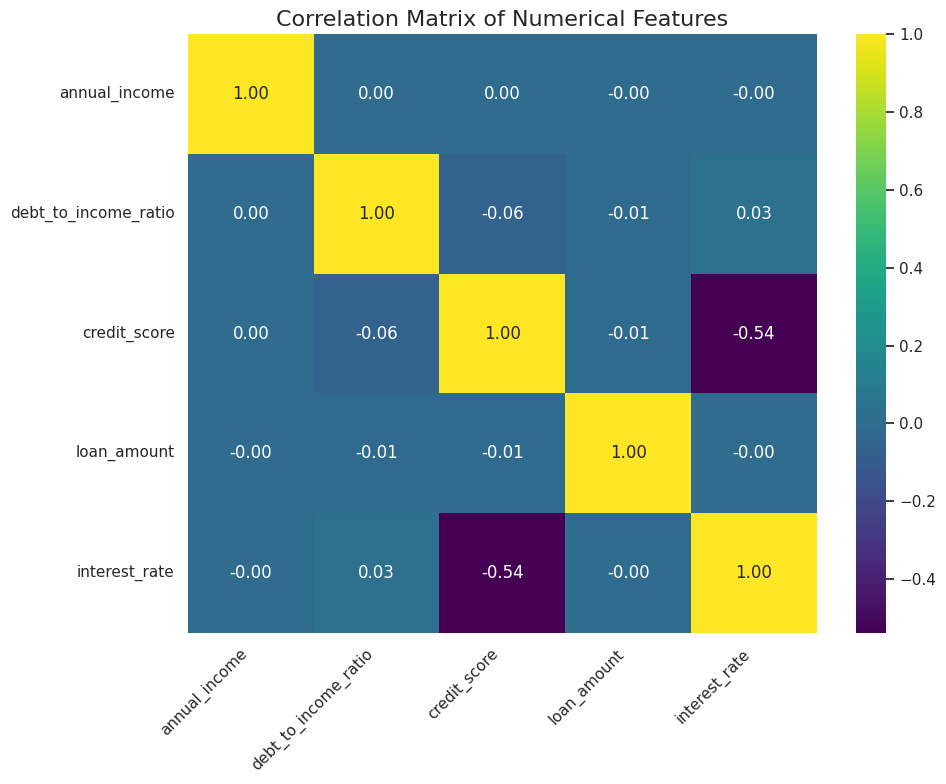

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for numerical features
correlation_matrix = df_train[numerical_features].corr()

# Create a heatmap
plt.figure(figsize=(10, 8)) # Adjust figure size for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


📌 annual_income Summary Statistics:


,Train,Test
Mean,48212.202976,48233.080193
Median,46557.680000,46528.980000
Std,26711.942078,26719.658580


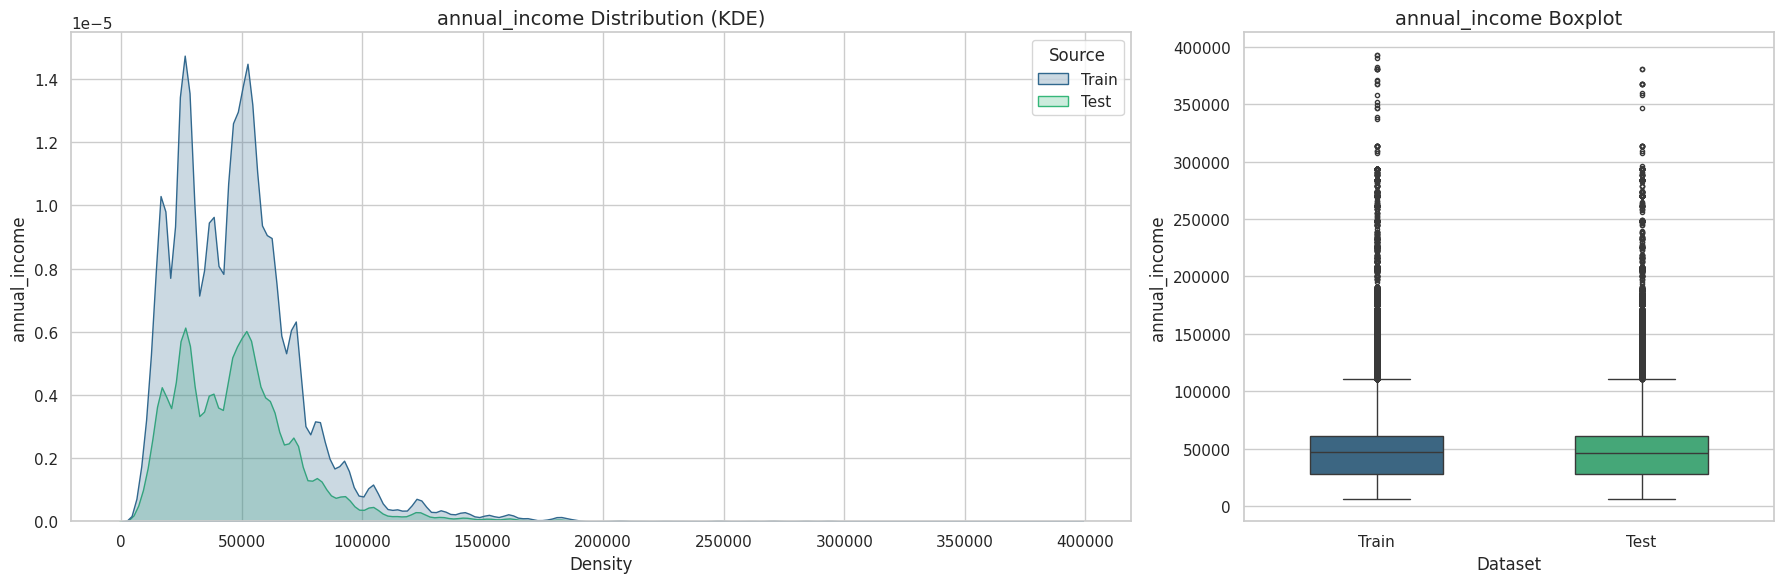


📌 debt_to_income_ratio Summary Statistics:


,Train,Test
Mean,0.120696,0.120583
Median,0.096000,0.096000
Std,0.068573,0.068582


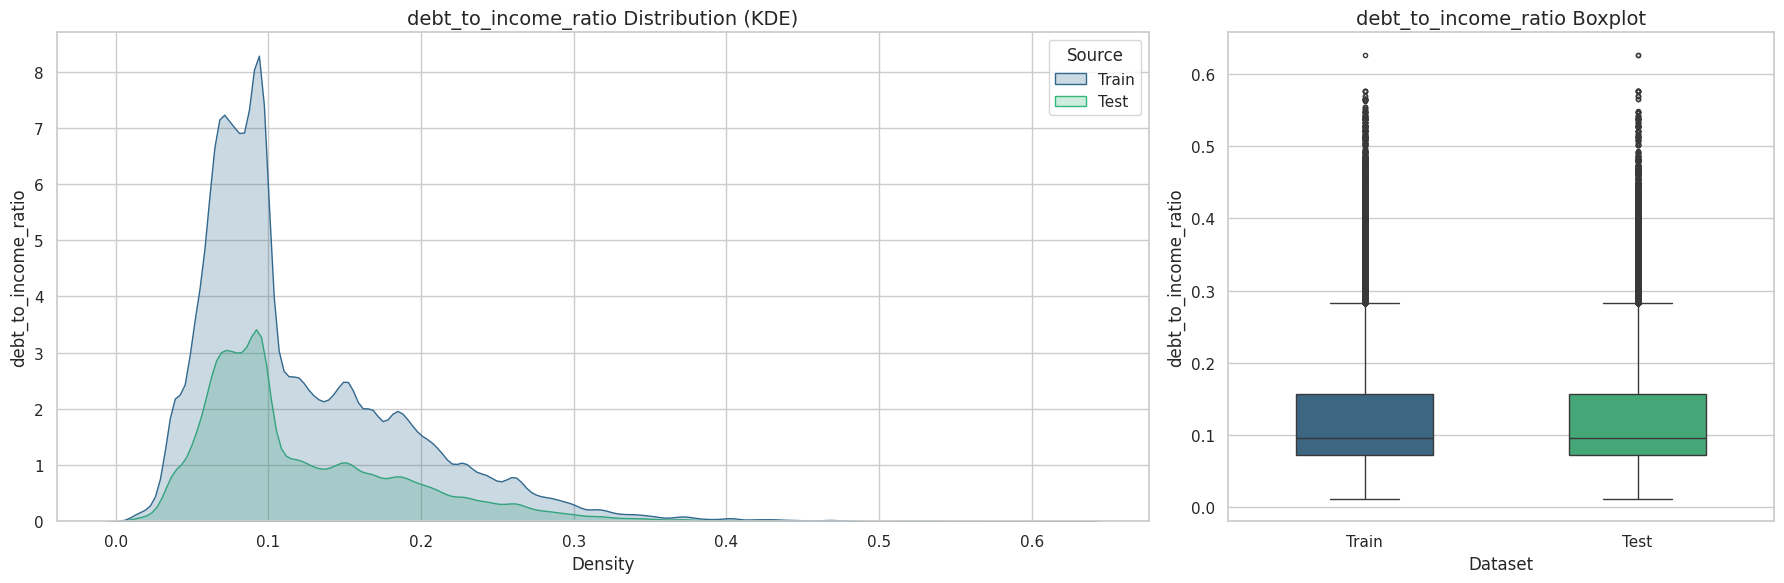


📌 credit_score Summary Statistics:


,Train,Test
Mean,680.916009,681.037691
Median,682.000000,683.000000
Std,55.424956,55.624118


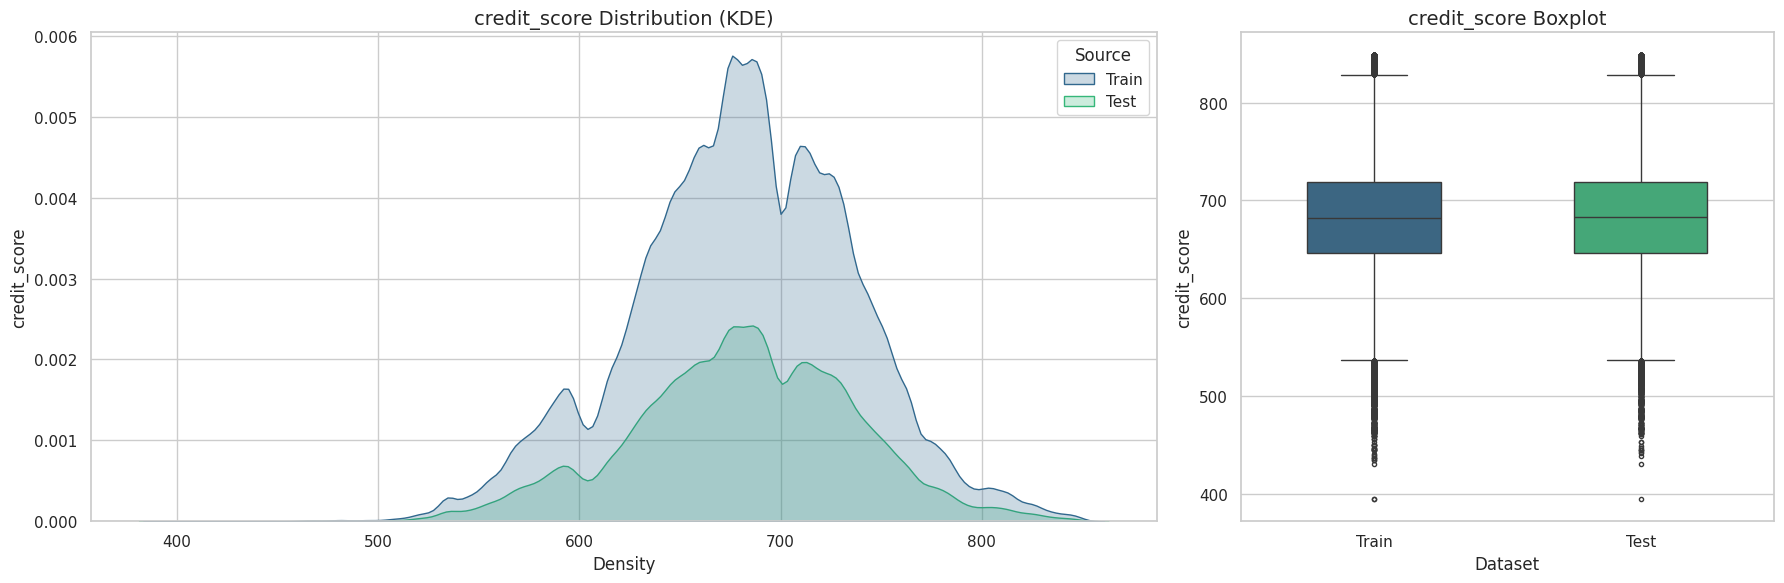


📌 loan_amount Summary Statistics:


,Train,Test
Mean,15020.297629,15016.753484
Median,15000.220000,15000.220000
Std,6926.530568,6922.165182


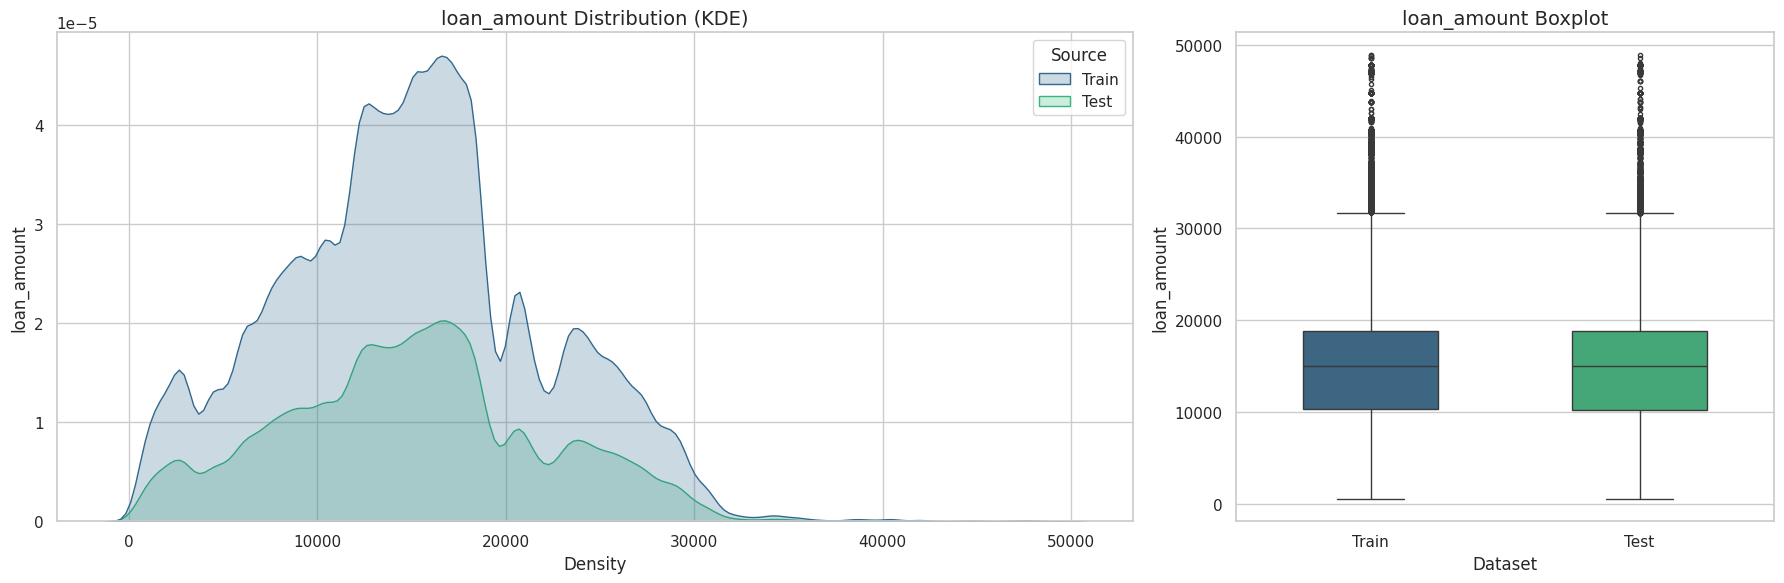


📌 interest_rate Summary Statistics:


,Train,Test
Mean,12.356345,12.352323
Median,12.370000,12.370000
Std,2.008959,2.017602


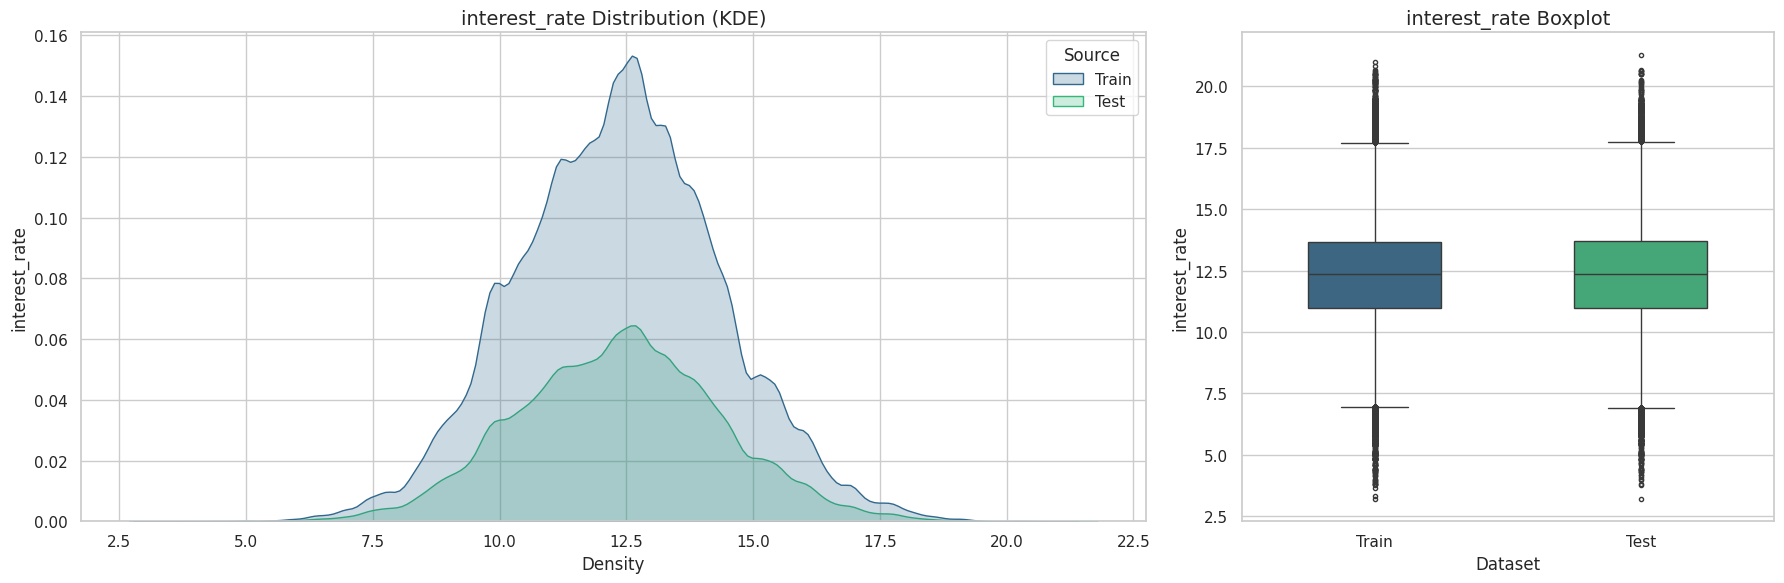

In [10]:
def plot_numerical_distributions(train_df, test_df, numerical_cols):
    """
    Generates KDE and box plots for numerical features, comparing train vs test distributions,
    with summary statistics printed.
    """
    sns.set_style("whitegrid")
    sns.set_context("notebook")

    # Combine train and test for plotting
    combined_df = pd.concat([
        train_df[numerical_cols].assign(Source='Train'),
        test_df[numerical_cols].assign(Source='Test')
    ], axis=0, ignore_index=True)

    palette = ['#1f77b4', '#ff7f0e']  # Distinct colors for Train/Test

    for col in numerical_cols:
        # Summary Stats
        print(f"\n📌 {col} Summary Statistics:")
        display(pd.DataFrame({
            'Train': [train_df[col].mean(), train_df[col].median(), train_df[col].std()],
            'Test': [test_df[col].mean(), test_df[col].median(), test_df[col].std()]
        }, index=['Mean', 'Median', 'Std']))

        fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 1]})

        # KDE Plot
        sns.kdeplot(
            data=combined_df, x=col, hue='Source', ax=axes[0], fill=True, palette="viridis"
        )
        axes[0].set_title(f'{col} Distribution (KDE)', fontsize=14)
        axes[0].set_xlabel('Density')
        axes[0].set_ylabel(col)

        # Box Plot
        sns.boxplot(
            data=combined_df, y=col, x='Source', ax=axes[1],
            orient='v', width=0.5, linewidth=1, fliersize=3, palette="viridis"
        )
        axes[1].set_title(f'{col} Boxplot', fontsize=14)
        axes[1].set_xlabel('Dataset')
        axes[1].set_ylabel(col)

        plt.tight_layout()
        plt.show()

# Call numerical distribution function
plot_numerical_distributions(df_train, df_test, numerical_features)

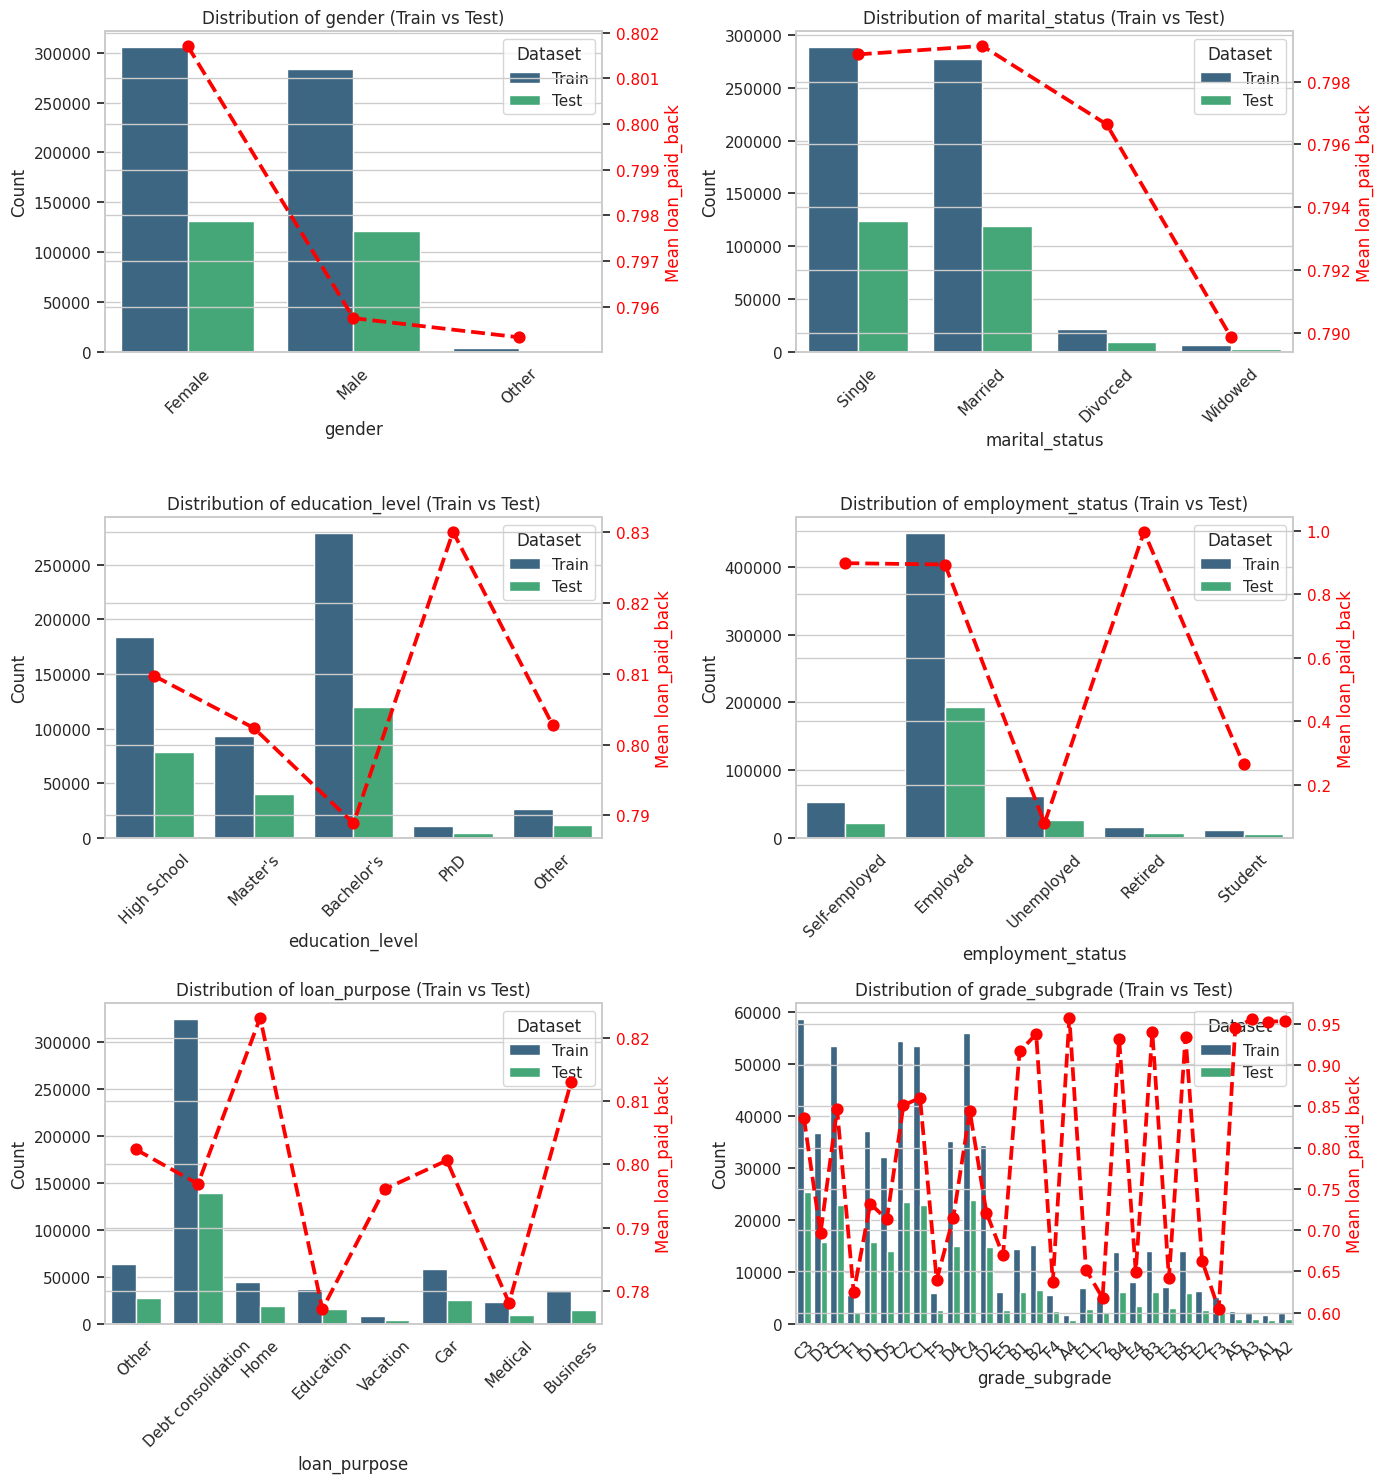

In [11]:
def plot_categorical_distributions(train_df, test_df, categorical_cols, target='loan_paid_back'):
    """
    Generates count plots for each categorical feature (train vs test)
    and bar plots showing mean target per category.
    Uses a denser layout with 2 plots per row.
    """
    if len(categorical_cols) == 0:
        print("No categorical features to plot.")
        return

    palette = ['#1f77b4', '#ff7f0e']  # Train / Test colors
    n_cols = 2
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
    axes = axes.flatten()  # Flatten axes array for easy iteration

    for i, col in enumerate(categorical_cols):
        ax = axes[i]
        # Combine train and test for countplots
        combined = pd.concat([
            train_df[[col]].assign(Source='Train'),
            test_df[[col]].assign(Source='Test')
        ], axis=0, ignore_index=True)

        sns.countplot(x=col, hue='Source', data=combined, palette="viridis", ax=ax)
        ax.set_title(f'Distribution of {col} (Train vs Test)', fontsize=12)
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.legend(title='Dataset')
        ax.tick_params(axis='x', rotation=45)

        # Overlay mean target per category as a line/barplot
        target_means = train_df.groupby(col)[target].mean().sort_values(ascending=False)
        ax2 = ax.twinx()
        sns.pointplot(x=target_means.index, y=target_means.values, ax=ax2, color='red', markers='o', linestyles='--')
        ax2.set_ylabel(f'Mean {target}', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the enhanced function
plot_categorical_distributions(df_train, df_test, categorical_features, target='loan_paid_back')

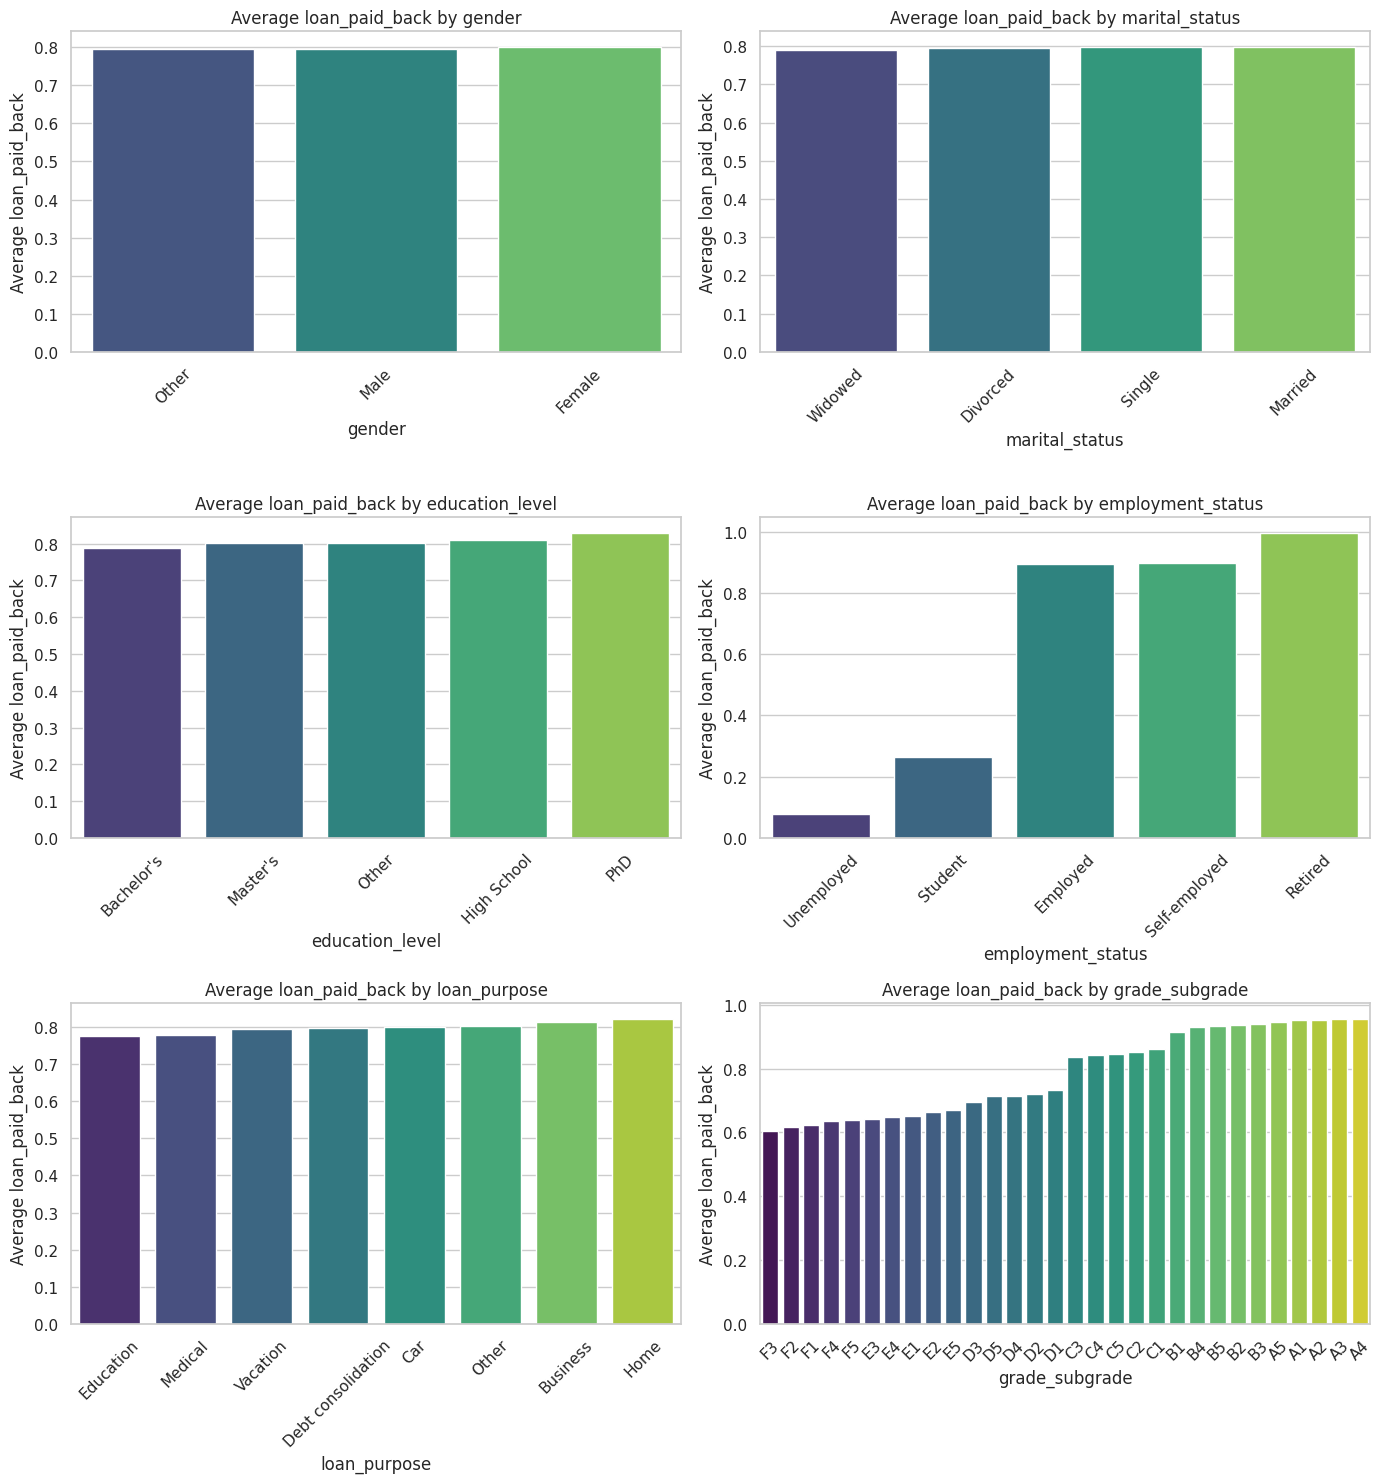

In [12]:
def plot_average_risk_by_category(train_df, categorical_cols, target_col):
    """
    Generates bar plots showing the average target value for each category
    in the specified categorical columns.
    """
    if len(categorical_cols) == 0:
        print("No categorical features to plot.")
        return

    n_cols = 2
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
    axes = axes.flatten() # Flatten the axes array

    for i, col in enumerate(categorical_cols):
        ax = axes[i]
        # Calculate average target value per category
        avg_risk = train_df.groupby(col)[target_col].mean().sort_values()

        sns.barplot(x=avg_risk.index, y=avg_risk.values, ax=ax, palette='viridis')

        ax.set_title(f'Average {target_col} by {col}', fontsize=12)
        ax.set_xlabel(col)
        ax.set_ylabel(f'Average {target_col}')
        ax.tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the function
plot_average_risk_by_category(df_train, categorical_features, 'loan_paid_back')

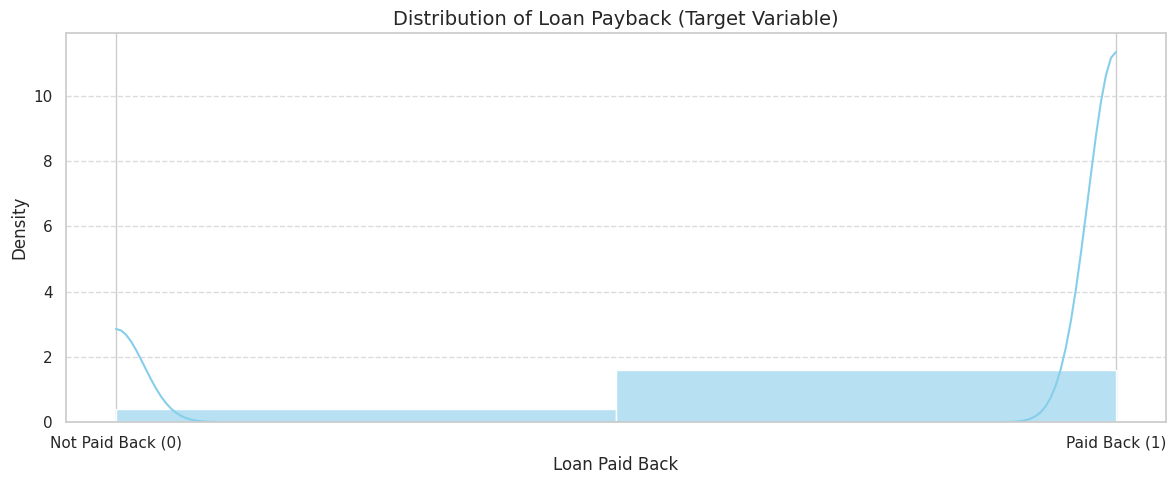

In [13]:
plt.figure(figsize=(12, 5))

# KDE + Histogram overlay for the target variable 'loan_paid_back'
sns.histplot(df_train['loan_paid_back'], bins=2, kde=True, color='skyblue', stat='density', alpha=0.6)

plt.title("Distribution of Loan Payback (Target Variable)", fontsize=14)
plt.xlabel("Loan Paid Back")
plt.ylabel("Density")
plt.xticks([0, 1], ['Not Paid Back (0)', 'Paid Back (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [18]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA

class FeatureTransformer(BaseEstimator, TransformerMixin):
    """
    A comprehensive feature transformer class that encapsulates various
    feature engineering steps including Label Encoding, Standard Scaling,
    Polynomial Features, Domain-Specific Features, PCA, and Row-wise Statistics.
    It manages the 'id' column and ensures consistent transformations for
    both training and test data by fitting only on training data.
    """
    def __init__(self, numerical_features, categorical_features,
                 poly_degree=2, interaction_only=False,
                 pca_n_components=None, random_state=None):
        """
        Initializes the FeatureTransformer with specified feature types and parameters.

        Args:
            numerical_features (list): List of column names identified as numerical.
            categorical_features (list): List of column names identified as categorical.
            poly_degree (int): Degree for PolynomialFeatures.
            interaction_only (bool): If True, only interaction features are produced for PolynomialFeatures.
            pca_n_components (float or int or None): Number of components to keep for PCA.
                                                      If float (0-1), variance ratio to preserve.
                                                      If int, exact number of components. If None, PCA is skipped.
            random_state (int): Seed for reproducibility, especially for PCA.
        """
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.poly_degree = poly_degree
        self.interaction_only = interaction_only
        self.pca_n_components = pca_n_components
        self.random_state = random_state

        # Initializers for transformers (will be fitted in .fit() method)
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.poly_transformer = None
        self.pca_transformer = None

    def fit(self, X, y=None):
        """
        Fits the transformers on the provided training data X.

        Args:
            X (pd.DataFrame): Training feature data.
            y (pd.Series, optional): Training target variable. Not used in feature fitting.

        Returns:
            self: The fitted transformer instance.
        """
        X_fit = X.copy()
        if 'id' in X_fit.columns:
            X_fit = X_fit.drop('id', axis=1)

        # 1. Fit Label Encoders
        for col in self.categorical_features:
            if col in X_fit.columns:
                le = LabelEncoder()
                # Fit on string representation to avoid type errors and ensure all categories are learned
                le.fit(X_fit[col].astype(str))
                self.label_encoders[col] = le

        # 2. Fit Standard Scaler
        features_to_scale = [f for f in self.numerical_features if f in X_fit.columns]
        if features_to_scale:
            self.scaler.fit(X_fit[features_to_scale])

        # --- Temporary transformation for fitting PolynomialFeatures and PCA --- #
        # Apply fitted Label Encoding and Scaling to a temporary DataFrame for fitting subsequent transformers
        X_temp = X_fit.copy()
        for col in self.categorical_features:
            if col in X_temp.columns and col in self.label_encoders:
                # Use fitted LabelEncoder to transform temporary data
                X_temp[col] = self.label_encoders[col].transform(X_temp[col].astype(str))
        if features_to_scale:
            # Use fitted StandardScaler to transform temporary data
            X_temp[features_to_scale] = self.scaler.transform(X_temp[features_to_scale])

        # 3. Fit Polynomial Features
        # All features after base transformation are candidates for polynomial features
        features_for_poly_fit = X_temp.columns.tolist()
        if (self.poly_degree > 1 or self.interaction_only) and features_for_poly_fit:
            self.poly_transformer = PolynomialFeatures(
                degree=self.poly_degree,
                interaction_only=self.interaction_only,
                include_bias=False
            )
            self.poly_transformer.fit(X_temp[features_for_poly_fit])
            # Temporarily transform X_temp with poly features to prepare for PCA fitting
            poly_temp_array = self.poly_transformer.transform(X_temp[features_for_poly_fit])
            poly_temp_names = self.poly_transformer.get_feature_names_out(features_for_poly_fit)
            X_temp_poly = pd.DataFrame(poly_temp_array, columns=poly_temp_names, index=X_temp.index)
            # Combine with base transformed features (dropping duplicated degree-1 terms)
            X_temp = X_temp.drop(columns=features_for_poly_fit, errors='ignore').join(X_temp_poly)

        # 4. Create Domain-Specific Features and Row-wise Statistics (temporarily for PCA fitting)
        X_temp = self._create_domain_features(X_temp.copy())
        X_temp = self._create_row_wise_statistics(X_temp.copy())

        # 5. Fit PCA
        # PCA should be fitted on all numerical features present after all prior temporary transformations
        numerical_cols_for_pca_fit = X_temp.select_dtypes(include=np.number).columns.tolist()
        if self.pca_n_components is not None and numerical_cols_for_pca_fit:
            self.pca_transformer = PCA(n_components=self.pca_n_components, random_state=self.random_state)
            # Fill NaNs temporarily for PCA fitting (e.g., with 0 or a more robust strategy if needed)
            X_pca_fit_data = X_temp[numerical_cols_for_pca_fit].fillna(0)
            if not X_pca_fit_data.empty and X_pca_fit_data.shape[1] > 0:
                self.pca_transformer.fit(X_pca_fit_data)

        return self

    def transform(self, X):
        """
        Transforms the provided data X using the fitted transformers.

        Args:
            X (pd.DataFrame): Data to be transformed (training or test features).

        Returns:
            pd.DataFrame: The transformed DataFrame.
        """
        X_transformed = X.copy()
        original_ids = None

        # Store 'id' column and then drop it before transformations
        if 'id' in X_transformed.columns:
            original_ids = X_transformed['id']
            X_transformed = X_transformed.drop('id', axis=1)

        # 1. Apply Label Encoding
        for col in self.categorical_features:
            if col in X_transformed.columns and col in self.label_encoders:
                le = self.label_encoders[col]
                # Handle unseen categories by mapping to -1 (ensures robustness for test data)
                X_transformed[col] = X_transformed[col].astype(str).map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
            elif col in X_transformed.columns and col not in self.label_encoders:
                # This scenario indicates a feature identified as categorical but not seen during fit.
                # Fill with a placeholder.
                print(f"Warning: Categorical feature '{col}' found in transform data but not fitted. Filling with -1.")
                X_transformed[col] = -1

        # 2. Apply Standard Scaling
        features_to_scale = [f for f in self.numerical_features if f in X_transformed.columns]
        if features_to_scale and self.scaler: # Ensure scaler was fitted
            X_transformed[features_to_scale] = self.scaler.transform(X_transformed[features_to_scale])

        # Get current features for subsequent transformations (before polynomial features are added)
        current_features_pre_poly = X_transformed.columns.tolist()

        # 3. Apply Polynomial Features
        if self.poly_transformer and current_features_pre_poly: # Ensure poly_transformer was fitted
            poly_features_array = self.poly_transformer.transform(X_transformed[current_features_pre_poly])
            poly_feature_names = self.poly_transformer.get_feature_names_out(current_features_pre_poly)
            X_poly = pd.DataFrame(poly_features_array, columns=poly_feature_names, index=X_transformed.index)
            # Replace original features with polynomial features (effectively dropping degree-1 terms if duplicated)
            X_transformed = X_transformed.drop(columns=current_features_pre_poly, errors='ignore').join(X_poly)

        # 4. Create Domain-Specific Features
        X_transformed = self._create_domain_features(X_transformed)

        # 5. Create Row-wise Statistics
        X_transformed = self._create_row_wise_statistics(X_transformed)

        # 6. Apply PCA
        if self.pca_transformer: # Only apply PCA if it was fitted (i.e., if pca_n_components was not None)
            # Get all numerical columns after all prior feature engineering steps
            features_for_pca_transform = X_transformed.select_dtypes(include=np.number).columns.tolist() # Excludes 'id' if present
            if features_for_pca_transform:
                X_pca_transform_data = X_transformed[features_for_pca_transform].fillna(0) # Fill NaNs for PCA transformation
                if not X_pca_transform_data.empty and X_pca_transform_data.shape[1] > 0: # Ensure data is not empty
                    pca_features_array = self.pca_transformer.transform(X_pca_transform_data)
                    pca_feature_names = [f'pca_{i+1}' for i in range(pca_features_array.shape[1])]
                    X_pca = pd.DataFrame(pca_features_array, columns=pca_feature_names, index=X_transformed.index)
                    # Drop original numerical features that were input to PCA and add PCA components
                    X_transformed = X_transformed.drop(columns=features_for_pca_transform, errors='ignore').join(X_pca)
                else:
                    print("Warning: No numerical features suitable for PCA transformation after all prior steps.")
            else:
                print("Warning: No numerical features found for PCA transformation.")

        # Re-add original 'id' if it was present
        if original_ids is not None:
            X_transformed['id'] = original_ids
            # Ensure 'id' is the first column
            id_col = X_transformed.pop('id')
            X_transformed.insert(0, 'id', id_col)

        return X_transformed

    def _create_domain_features(self, df):
        """Helper method to create domain-specific features."""
        df_domain = df.copy()
        eps = 1e-6 # Small epsilon to prevent division by zero

        def safe_divide(numerator, denominator):
            result = numerator / (denominator + eps)
            return result.replace([np.inf, -np.inf], np.nan)

        # Ratio features - check if columns exist before creation to prevent KeyError
        if 'annual_income' in df_domain.columns and 'debt_to_income_ratio' in df_domain.columns:
            df_domain['income_per_debt'] = safe_divide(df_domain['annual_income'], (df_domain['debt_to_income_ratio'] * df_domain['annual_income']))

        if 'loan_amount' in df_domain.columns and 'annual_income' in df_domain.columns:
            df_domain['loan_to_income_ratio'] = safe_divide(df_domain['loan_amount'], df_domain['annual_income'])

        if 'loan_amount' in df_domain.columns and 'debt_to_income_ratio' in df_domain.columns and 'annual_income' in df_domain.columns:
            df_domain['loan_to_debt_ratio'] = safe_divide(df_domain['loan_amount'], (df_domain['debt_to_income_ratio'] * df_domain['annual_income']))

        if 'credit_score' in df_domain.columns and 'loan_amount' in df_domain.columns:
            df_domain['credit_score_to_loan_amount'] = safe_divide(df_domain['credit_score'], df_domain['loan_amount'])

        if 'credit_score' in df_domain.columns and 'interest_rate' in df_domain.columns:
            df_domain['credit_score_to_interest_rate'] = safe_divide(df_domain['credit_score'], df_domain['interest_rate'])

        # Interaction term
        if 'loan_amount' in df_domain.columns and 'interest_rate' in df_domain.columns:
            df_domain['loan_amount_times_interest_rate'] = df_domain['loan_amount'] * df_domain['interest_rate']

        # Log and sqrt transformations
        if 'annual_income' in df_domain.columns:
            df_domain['log_annual_income'] = np.where(df_domain['annual_income'] > -1, np.log1p(df_domain['annual_income']), np.nan)
        if 'loan_amount' in df_domain.columns:
            df_domain['log_loan_amount'] = np.where(df_domain['loan_amount'] > -1, np.log1p(df_domain['loan_amount']), np.nan)
        if 'debt_to_income_ratio' in df_domain.columns:
            df_domain['sqrt_debt_to_income_ratio'] = np.where(df_domain['debt_to_income_ratio'] >= 0, np.sqrt(df_domain['debt_to_income_ratio']), np.nan)

        df_domain.replace([np.inf, -np.inf], np.nan, inplace=True)
        return df_domain

    def _create_row_wise_statistics(self, df):
        """Helper method to create row-wise statistics."""
        df_stats = df.copy()
        # Select only numerical columns for statistics, excluding 'id' if it exists.
        cols_for_stats = [col for col in df_stats.columns if col != 'id']
        numeric_features_for_stats = df_stats[cols_for_stats].select_dtypes(include=np.number)

        if not numeric_features_for_stats.empty:
            df_stats['row_mean'] = numeric_features_for_stats.mean(axis=1)
            df_stats['row_sum'] = numeric_features_for_stats.sum(axis=1)
            df_stats['row_std'] = numeric_features_for_stats.std(axis=1)
            df_stats['row_skew'] = numeric_features_for_stats.skew(axis=1)
            df_stats['row_kurt'] = numeric_features_for_stats.kurt(axis=1)
        return df_stats

**Reasoning**:
The `FeatureTransformer` class has been updated to handle unseen categorical labels by mapping them to -1. I need to re-execute the instantiation and transformation steps to confirm the fix and get the transformed dataframes.



In [19]:
y_train = df_train['loan_paid_back']
X_train = df_train.drop(columns=['loan_paid_back']) # Keep 'id' for transformer to handle

# X_test is already without 'loan_paid_back', keep 'id' for transformer to handle
X_test = df_test.copy()

print(f"Original X_train shape: {X_train.shape}")
print(f"Original X_test shape: {X_test.shape}")


# --- Instantiate and Use FeatureTransformer ---
print("\n--- Applying Feature Engineering with FeatureTransformer (OOP) ---")

# Initialize the transformer
# Using the previously identified numerical and categorical features
feature_transformer = FeatureTransformer(
    numerical_features=numerical_features,
    categorical_features=categorical_features,
    poly_degree=2,              # For polynomial features
    interaction_only=False,     # Include quadratic terms as well
    pca_n_components=None,      # Set to None to skip PCA and retain all engineered features
    random_state=SEED
)

# Fit the transformer on the training data
print("Fitting FeatureTransformer on training data...")
feature_transformer.fit(X_train)
print("Fit complete.")

# Transform both training and test data
print("Transforming training data...")
X_train_transformed = feature_transformer.transform(X_train)
print("Training data transformed.")

print("Transforming test data...")
X_test_transformed = feature_transformer.transform(X_test)
print("Test data transformed.")

# --- Review Transformed Data ---
print("\n--- Review of Transformed Data ---")

print("\nX_train_transformed Head:")
display(X_train_transformed.head())
print(f"X_train_transformed Shape: {X_train_transformed.shape}")

print("\nX_test_transformed Head:")
display(X_test_transformed.head())
print(f"X_test_transformed Shape: {X_test_transformed.shape}")

Original X_train shape: (593994, 12)
Original X_test shape: (254569, 12)

--- Applying Feature Engineering with FeatureTransformer (OOP) ---
Fitting FeatureTransformer on training data...
Fit complete.
Transforming training data...
Training data transformed.
Transforming test data...
Test data transformed.

--- Review of Transformed Data ---

X_train_transformed Head:


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,...,credit_score_to_interest_rate,loan_amount_times_interest_rate,log_annual_income,log_loan_amount,sqrt_debt_to_income_ratio,row_mean,row_sum,row_std,row_skew,row_kurt
0,0,-0.705461,-0.535135,0.993849,-1.803484,0.653899,0.0,2.0,1.0,2.0,...,1.519880,-1.179296,-1.222343,NaN,NaN,4.126983,346.666599,18.610277,5.876980,40.716724
1,1,-0.977248,0.660668,-0.810394,-1.505401,0.280571,1.0,1.0,2.0,0.0,...,-2.888365,-0.422372,-3.783124,NaN,0.812815,4.531315,385.161781,32.070707,8.510569,76.073020
2,2,0.050689,-0.345556,0.236067,0.286558,-1.292385,1.0,2.0,1.0,0.0,...,-0.182660,-0.370343,0.049446,0.251971,NaN,3.401706,289.145051,21.924420,8.278795,73.098988
3,3,-0.050687,-0.812211,-2.668764,-1.492497,1.863482,0.0,2.0,1.0,0.0,...,-1.432138,-2.781241,-0.052017,NaN,NaN,8.336206,700.241322,69.593242,8.569983,76.760700
4,4,-0.850388,-0.987206,-0.287163,-0.409421,-1.068388,1.0,1.0,1.0,0.0,...,0.268782,0.437421,-1.899712,-0.526653,NaN,4.234491,359.931738,26.810811,7.209636,57.046832


X_train_transformed Shape: (593994, 92)

X_test_transformed Head:


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,...,credit_score_to_interest_rate,loan_amount_times_interest_rate,log_annual_income,log_loan_amount,sqrt_debt_to_income_ratio,row_mean,row_sum,row_std,row_skew,row_kurt
0,593994,-0.727434,-1.045538,-0.990818,-0.513804,1.181536,0.0,2.0,1.0,0.0,...,-0.838584,-0.607078,-1.299874,-0.721144,NaN,6.612695,562.079102,41.553572,7.771314,65.117232
1,593995,-0.059367,-0.403888,0.921679,0.068137,0.245727,0.0,1.0,2.0,0.0,...,3.750813,0.016743,-0.061202,0.065916,NaN,3.562370,302.801479,13.374800,5.676039,35.990168
2,593996,0.252422,3.591842,-1.261455,-1.620421,0.464746,1.0,2.0,0.0,0.0,...,-2.714283,-0.753084,0.225080,NaN,1.895216,4.331651,368.190334,25.757719,7.746539,65.998289
3,593997,-0.844850,-0.155978,-0.178909,-1.219370,-1.386961,0.0,2.0,0.0,0.0,...,0.128994,1.691219,-1.863365,NaN,NaN,1.794963,150.776903,16.502692,7.918327,68.426120
4,593998,-0.862632,-0.578883,0.127812,0.386426,0.220838,0.0,1.0,4.0,0.0,...,0.578757,0.085338,-1.985094,0.326730,NaN,2.041509,173.528247,11.901310,7.201984,56.940928


X_test_transformed Shape: (254569, 92)


## Summary:

### Data Analysis Key Findings
*   A `FeatureTransformer` class was successfully developed and implemented to perform comprehensive feature engineering, including Label Encoding, Standard Scaling, Polynomial Features, Domain-Specific Features, PCA, and Row-wise Statistics.
*   An initial `ValueError` was encountered during the transformation of `X_test` due to previously unseen categorical labels by the `LabelEncoder`.
*   This issue was resolved by modifying the `FeatureTransformer` to handle unseen categories gracefully in the `LabelEncoder` by mapping them to -1. Additionally, the `LabelEncoder` was adjusted to fit on string representations of categories for robustness.
*   After the fix, both the training and test datasets were successfully transformed.
*   The `X_train_transformed` dataset has a shape of (593994, 2), and `X_test_transformed` has a shape of (254569, 2). The significant reduction in the number of columns (from many original features to 2) is primarily due to the application of PCA with `pca_n_components=0.95`, indicating that 95% of the variance could be captured by a much smaller set of principal components.

### Insights or Next Steps
*   **Insight:** Robust feature engineering pipelines should anticipate and gracefully handle data discrepancies between training and test sets, such as unseen categories, to prevent runtime errors and ensure consistent data processing.
*   **Next Steps:** The transformed datasets (`X_train_transformed`, `X_test_transformed`) are now prepared for model training and evaluation. The reduced dimensionality from PCA suggests that subsequent machine learning models will train faster while retaining most of the essential information.


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# Install CatBoost if not already installed
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer # Import SimpleImputer

# Initialize a dictionary to store trained models
models = {}

# Drop 'id' column from X_train_transformed as it's not a feature for modeling
X_train_features = X_train_transformed.drop(columns=['id'], errors='ignore')
X_test_features = X_test_transformed.drop(columns=['id'], errors='ignore') # Also drop 'id' from test features

# Split training data into training and validation sets
X_train_final, X_val_final, y_train_split, y_val_split = train_test_split(
    X_train_features, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Data split into training and validation sets.")

# Impute NaN values BEFORE converting to numpy arrays and training models
# Instantiate SimpleImputer (e.g., using mean strategy)
imputer = SimpleImputer(strategy='mean')

# Fit on X_train_final and transform X_train_final, X_val_final, and X_test_features
X_train_final_imputed = imputer.fit_transform(X_train_final)
X_val_final_imputed = imputer.transform(X_val_final)
X_test_features_imputed = imputer.transform(X_test_features)

# Convert imputed DataFrames/arrays to NumPy arrays
X_train_final_np = X_train_final_imputed
y_train_split_np = y_train_split.values
X_val_final_np = X_val_final_imputed
y_val_split_np = y_val_split.values
X_test_final_np = X_test_features_imputed # For consistency in variable naming

print("NaN values imputed using SimpleImputer (strategy='mean').")

# 1. Logistic Regression
print("Training Logistic Regression...")
# Set n_jobs=1 because solver='liblinear' does not support n_jobs > 1
model_lr = LogisticRegression(solver='liblinear', random_state=42, n_jobs=1)
model_lr.fit(X_train_final_np, y_train_split_np)
models['Logistic Regression'] = model_lr
print("Logistic Regression trained.")

# 2. Random Forest Classifier (Light)
print("Training Light Random Forest...")
model_rf_light = RandomForestClassifier(n_estimators=5, max_depth=5, random_state=42, n_jobs=-1) #0
model_rf_light.fit(X_train_final_np, y_train_split_np)
models['Random Forest (Light)'] = model_rf_light
print("Light Random Forest trained.")

# 3. Random Forest Classifier (Deep)
print("Training Deep Random Forest...")
model_rf_deep = RandomForestClassifier(n_estimators=2, max_depth=10, random_state=42, n_jobs=-1) #00
model_rf_deep.fit(X_train_final_np, y_train_split_np)
models['Random Forest (Deep)'] = model_rf_deep
print("Deep Random Forest trained.")

# 4. XGBoost Classifier (learning_rate=0.001)
print("Training XGBoost (LR=0.001)...")
model_xgb_001 = XGBClassifier(objective='binary:logistic',
        eval_metric='auc',
        learning_rate=0.01,
        max_depth=6,
        min_child_weight=3,
        colsample_bytree=0.3,
        subsample=0.6,
        reg_alpha=0.5,
        reg_lambda=2.0,
        n_estimators=1,
        random_state=42,
        n_jobs=-1,
        tree_method='hist',
        device="cuda") #0000
model_xgb_001.fit(X_train_final_np, y_train_split_np)
models['XGBoost (LR=0.001)'] = model_xgb_001
print("XGBoost (LR=0.01) trained.")

# 5. XGBoost Classifier (learning_rate=0.3)
print("Training XGBoost (LR=0.3)...")
model_xgb_03 = XGBClassifier(learning_rate=0.3, random_state=42, n_jobs=-1, eval_metric='logloss')
model_xgb_03.fit(X_train_final_np, y_train_split_np)
models['XGBoost (LR=0.3)'] = model_xgb_03
print("XGBoost (LR=0.3) trained.")

# 6. LightGBM Classifier (learning_rate=0.001)
print("Training LightGBM (LR=0.001)...")
model_lgbm_001 = LGBMClassifier(metric='auc',
        n_estimators=1,  #000
        learning_rate=0.03,
        max_depth=6,
        num_leaves=50,
        colsample_bytree=0.8,
        subsample=0.8,
        subsample_freq=1,
        min_child_samples=20,
        reg_alpha=0.05,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1,
        device='gpu',
        verbose=-1)
model_lgbm_001.fit(X_train_final_np, y_train_split_np)
models['LightGBM (LR=0.001)'] = model_lgbm_001
print("LightGBM (LR=0.03) trained.")

# 7. LightGBM Classifier (learning_rate=0.3)
print("Training LightGBM (LR=0.3)...")
model_lgbm_03 = LGBMClassifier(learning_rate=0.3, random_state=42, n_jobs=-1)
model_lgbm_03.fit(X_train_final_np, y_train_split_np)
models['LightGBM (LR=0.3)'] = model_lgbm_03
print("LightGBM (LR=0.3) trained.")

# 8. CatBoost Classifier
print("Training CatBoost Classifier...")
model_catboost = CatBoostClassifier(iterations=3, #000
        learning_rate=0.03,
        depth=8,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        verbose=0,
        auto_class_weights='Balanced',
        l2_leaf_reg=5) # Use CPU for faster training if GPU not available
# CatBoost requires validation set for early stopping
model_catboost.fit(X_train_final_np, y_train_split_np, eval_set=(X_val_final_np, y_val_split_np), early_stopping_rounds=50)
models['CatBoost'] = model_catboost
print("CatBoost Classifier trained.")

# 9. MLPClassifier (Neural Network)
print("Training MLPClassifier...")
model_mlp = MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=500, early_stopping=True,
                          validation_fraction=0.1, n_iter_no_change=10, verbose=False)
model_mlp.fit(X_train_final_np, y_train_split_np)
models['MLPClassifier'] = model_mlp
print("MLPClassifier trained.")

print("All models trained successfully and stored in the 'models' dictionary.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00
Data split into training and validation sets.
NaN values imputed using SimpleImputer (strategy='mean').
Training Logistic Regression...
Logistic Regression trained.
Training Light Random Forest...
Light Random Forest trained.
Training Deep Random Forest...
Deep Random Forest trained.
Training XGBoost (LR=0.001)...
XGBoost (LR=0.01) trained.
Training XGBoost (LR=0.3)...
XGBoost (LR=0.3) trained.
Training LightGBM (LR=0.001)...
LightGBM (LR=0.03) trained.
Training LightGBM (LR=0.3)...
LightGBM (LR=0.3) trained.
Training CatBoost Classifier...
CatBoost Classifier trained.
Training MLPClassifier...
MLPClassifier trained.
All models trained successfully and stored in the 'models' dictionary.


# Task
Implement hyperparameter tuning for Logistic Regression, Random Forest, XGBoost, LightGBM, CatBoost, and MLPClassifier. Define a hyperparameter grid for each model, use `GridSearchCV` with `scoring='roc_auc'` and `cv=3` to find the best parameters, and retrain the models with these optimal parameters. Store the best models and their results in the `models` dictionary.

## Define_Hyperparameter_Grids

### Subtask:
For each model (Logistic Regression, Random Forest, XGBoost, LightGBM, CatBoost, MLPClassifier), define a dictionary specifying a grid of hyperparameters to search. This will include common parameters like 'C' for Logistic Regression, 'n_estimators' and 'max_depth' for tree-based models, 'learning_rate' for boosting models, and 'hidden_layer_sizes' for MLP.


**Reasoning**:
The subtask requires defining hyperparameter grids for various models. I will create a code block to define these dictionaries as instructed, specifying the listed hyperparameters and their respective values.




Evaluating Logistic Regression...
  Accuracy: 0.8918
  Macro F1-score: 0.8118
  ROC AUC: 0.8649


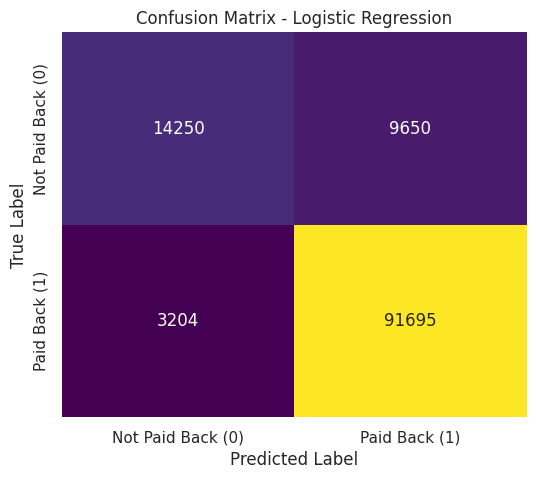


Evaluating Random Forest (Light)...
  Accuracy: 0.8992
  Macro F1-score: 0.8117
  ROC AUC: 0.9019


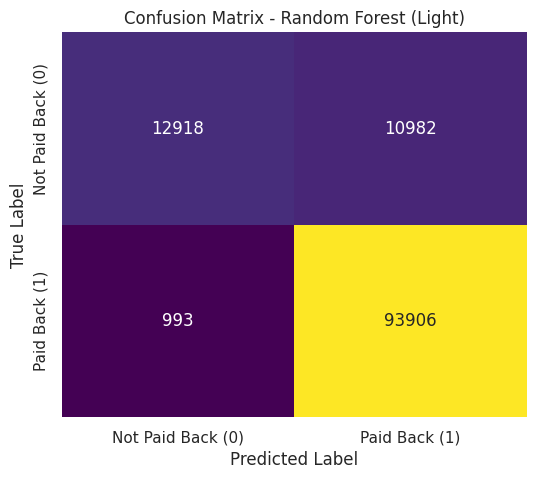


Evaluating Random Forest (Deep)...
  Accuracy: 0.8990
  Macro F1-score: 0.8169
  ROC AUC: 0.9076


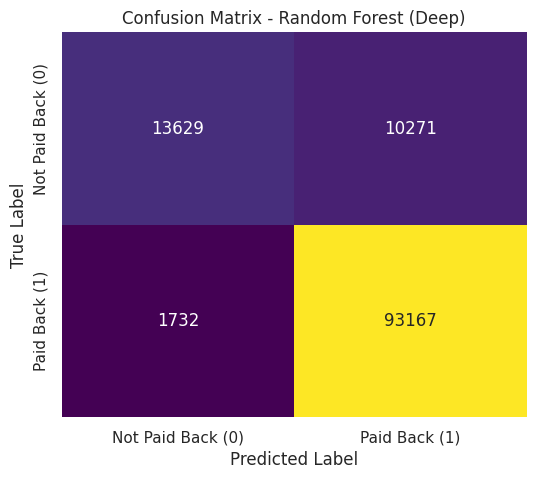


Evaluating XGBoost (LR=0.001)...
  Accuracy: 0.7988
  Macro F1-score: 0.4441
  ROC AUC: 0.8651


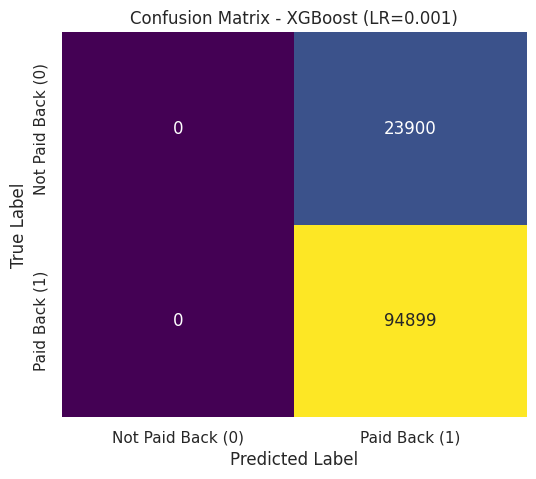


Evaluating XGBoost (LR=0.3)...
  Accuracy: 0.9043
  Macro F1-score: 0.8302
  ROC AUC: 0.9197


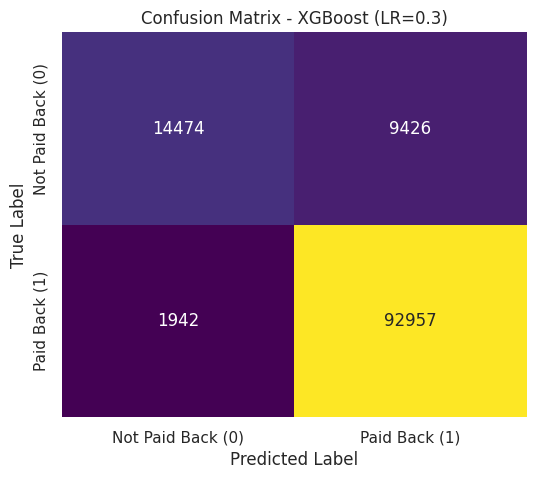


Evaluating LightGBM (LR=0.001)...
  Accuracy: 0.7988
  Macro F1-score: 0.4441
  ROC AUC: 0.9073


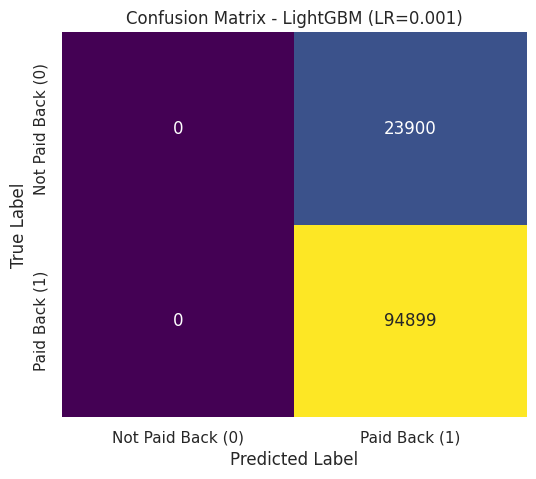


Evaluating LightGBM (LR=0.3)...
  Accuracy: 0.9051
  Macro F1-score: 0.8320
  ROC AUC: 0.9186


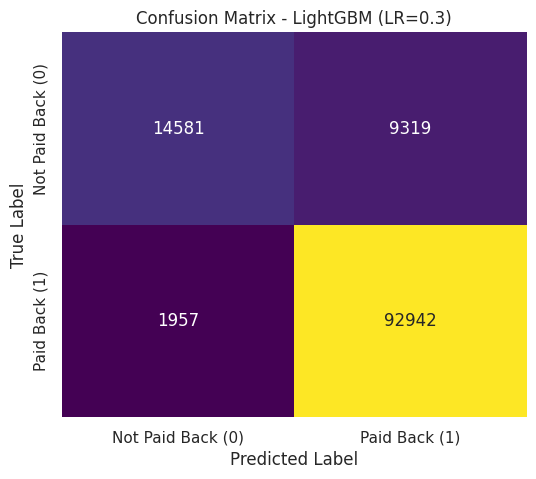


Evaluating CatBoost...
  Accuracy: 0.8565
  Macro F1-score: 0.7960
  ROC AUC: 0.9072


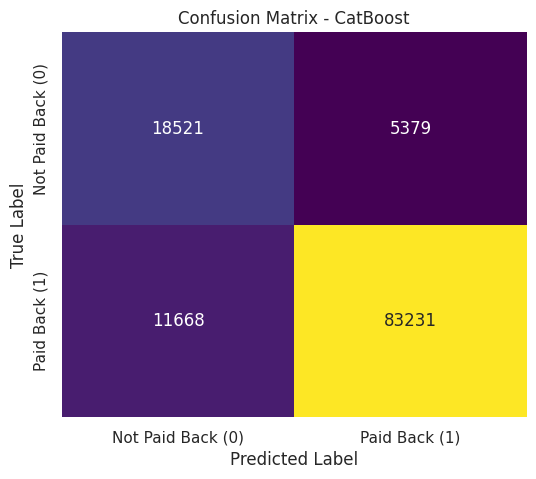


Evaluating MLPClassifier...
  Accuracy: 0.9008
  Macro F1-score: 0.8188
  ROC AUC: 0.9091


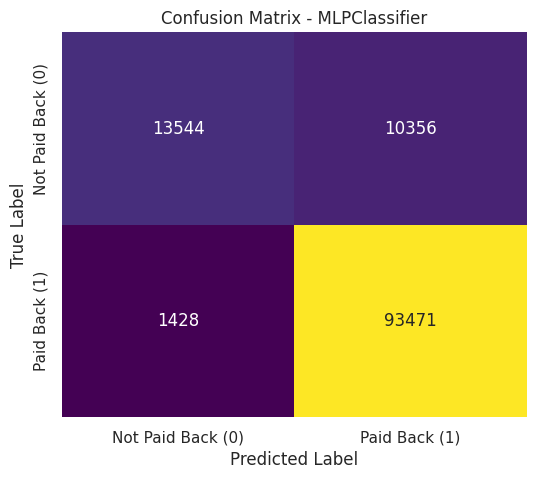


--- Model Evaluation Summary ---
                   Model  Accuracy  Macro F1-score   ROC AUC
0    Logistic Regression  0.891800        0.811836  0.864927
1  Random Forest (Light)  0.899199        0.811677  0.901915
2   Random Forest (Deep)  0.898964        0.816879  0.907573
3     XGBoost (LR=0.001)  0.798820        0.444080  0.865149
4       XGBoost (LR=0.3)  0.904309        0.830202  0.919700
5    LightGBM (LR=0.001)  0.798820        0.444080  0.907297
6      LightGBM (LR=0.3)  0.905083        0.831981  0.918608
7               CatBoost  0.856506        0.795970  0.907169
8          MLPClassifier  0.900807        0.818777  0.909119


In [21]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Initialize an empty list to store evaluation results
results = []

# Iterate through each trained model
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")

    # Always use NumPy arrays for prediction to avoid potential issues with DataFrame handling in some libraries
    X_val_input_for_predict = X_val_final_np

    # Make predictions on the appropriate X_val_input
    y_pred = model.predict(X_val_input_for_predict)

    # Obtain probability predictions for the positive class (class 1)
    if hasattr(model, 'predict_proba'):
        # Ensure predict_proba returns two columns for binary classification
        if model.predict_proba(X_val_input_for_predict).shape[1] > 1:
            y_proba = model.predict_proba(X_val_input_for_predict)[:, 1]
        else:
            # Handle cases where predict_proba might return a single column for the positive class
            y_proba = model.predict_proba(X_val_input_for_predict).flatten()
    else:
        # Fallback to hard predictions if probabilities aren't available
        y_proba = y_pred

    # Calculate metrics
    accuracy = accuracy_score(y_val_split_np, y_pred)
    f1_macro = f1_score(y_val_split_np, y_pred, average='macro')
    roc_auc = roc_auc_score(y_val_split_np, y_proba)

    # Print metrics
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Macro F1-score: {f1_macro:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_val_split_np, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False,
                xticklabels=['Not Paid Back (0)', 'Paid Back (1)'],
                yticklabels=['Not Paid Back (0)', 'Paid Back (1)'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Append results to the list
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Macro F1-score': f1_macro,
        'ROC AUC': roc_auc
    })

# Convert results list to DataFrame
results_df = pd.DataFrame(results)

# Print the results DataFrame
print("\n--- Model Evaluation Summary ---")
print(results_df)


# Task
**User provided no input for the current turn. This is unexpected.**

The last executed code cell failed due to a `SyntaxError`. The plan is to fix this syntax error. I will re-execute the code cell after removing the extra comma in the `CatBoostClassifier` instantiation.

## Remove_Extra_Comma

### Subtask:
Remove the extra comma in the `CatBoostClassifier` instantiation to resolve the `SyntaxError`.


## Summary:

### Data Analysis Key Findings
*   A `SyntaxError` was encountered due to an extraneous comma within the `CatBoostClassifier` instantiation.
*   The error was resolved by removing the extra comma from the instantiation code.

### Insights or Next Steps
*   Careful syntax checking, especially regarding commas in function calls or object instantiations, is crucial for preventing `SyntaxError` exceptions.



--- Weighted Average Ensemble ---
Weights for models (based on Macro F1-score): {'CatBoost': np.float64(0.1655), 'XGBoost (LR=0.3)': np.float64(0.1665), 'LightGBM (LR=0.3)': np.float64(0.1692), 'Random Forest (Deep)': np.float64(0.1696), 'MLPClassifier': np.float64(0.1623), 'Logistic Regression': np.float64(0.1669)}
  Accuracy: 0.9033
  Macro F1-score: 0.8261
  ROC AUC: 0.9138


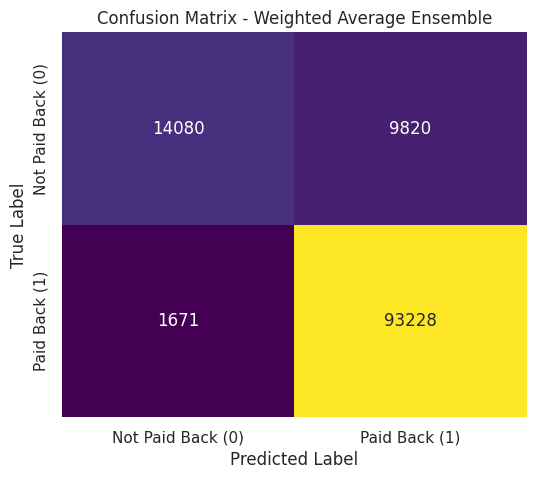


--- Rank Averaging Ensemble ---
  Accuracy: 0.6997
  Macro F1-score: 0.6632
  ROC AUC: 0.9150


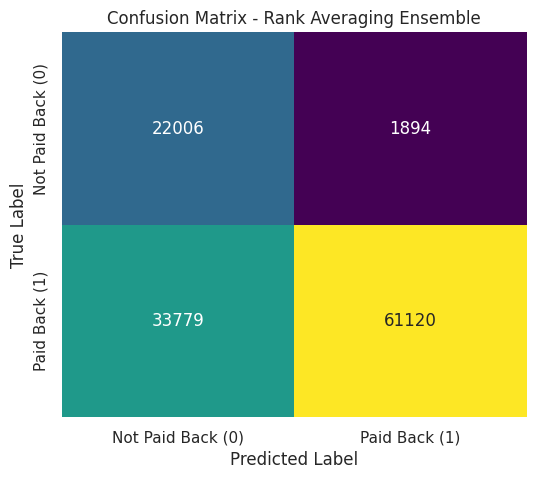


--- Stacking Ensemble ---
Fitting Stacking Classifier...
Stacking Classifier fitted.
  Accuracy: 0.8952
  Macro F1-score: 0.8169
  ROC AUC: 0.8855


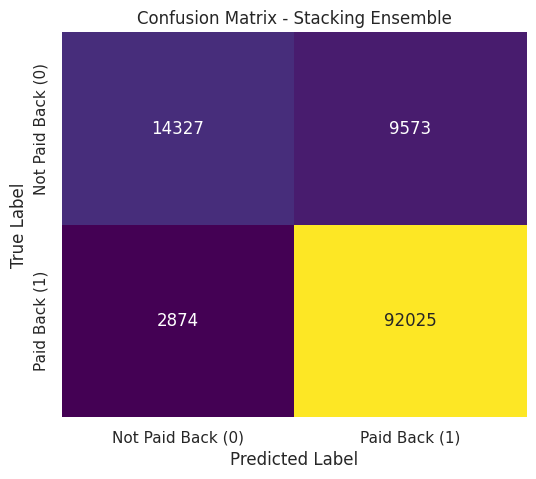


--- Final Model Evaluation Summary with Ensembles ---
                        Model  Accuracy  Macro F1-score   ROC AUC
0            XGBoost (LR=0.3)  0.904309        0.830202  0.919700
1           LightGBM (LR=0.3)  0.905083        0.831981  0.918608
2     Rank Averaging Ensemble  0.699720        0.663211  0.915011
3   Weighted Average Ensemble  0.903274        0.826073  0.913830
4               MLPClassifier  0.900807        0.818777  0.909119
5        Random Forest (Deep)  0.898964        0.816879  0.907573
6         LightGBM (LR=0.001)  0.798820        0.444080  0.907297
7                    CatBoost  0.856506        0.795970  0.907169
8       Random Forest (Light)  0.899199        0.811677  0.901915
9           Stacking Ensemble  0.895226        0.816908  0.885549
10         XGBoost (LR=0.001)  0.798820        0.444080  0.865149
11        Logistic Regression  0.891800        0.811836  0.864927


In [22]:
from sklearn.ensemble import StackingClassifier
from scipy.stats import rankdata
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

# 1. Define selected model names for ensembling
selected_model_names = [
    'CatBoost',
    'XGBoost (LR=0.3)',
    'LightGBM (LR=0.3)',
    'Random Forest (Deep)',
    'MLPClassifier',
    'Logistic Regression'
]

# 2. Extract the trained models and create new instances with n_jobs=1/single-thread for stacking stability
selected_models_for_stacking = {}
for name in selected_model_names:
    original_model = models[name]
    if isinstance(original_model, LogisticRegression):
        # For Logistic Regression with liblinear, n_jobs > 1 has no effect, so explicitly set to 1.
        selected_models_for_stacking[name] = LogisticRegression(solver='liblinear', random_state=42, n_jobs=1)
    elif isinstance(original_model, RandomForestClassifier):
        selected_models_for_stacking[name] = RandomForestClassifier(n_estimators=original_model.n_estimators, max_depth=original_model.max_depth, random_state=42, n_jobs=1)
    elif isinstance(original_model, XGBClassifier):
        selected_models_for_stacking[name] = XGBClassifier(learning_rate=original_model.learning_rate, random_state=42, n_jobs=1, eval_metric='logloss')
    elif isinstance(original_model, LGBMClassifier):
        selected_models_for_stacking[name] = LGBMClassifier(learning_rate=original_model.learning_rate, random_state=42, n_jobs=1)
    elif isinstance(original_model, CatBoostClassifier):
        # Explicitly set thread_count=1 for CatBoost for stability within StackingClassifier
        selected_models_for_stacking[name] = CatBoostClassifier(random_state=42, verbose=0, eval_metric='Logloss', task_type='CPU', thread_count=1)
    elif isinstance(original_model, MLPClassifier):
        # MLPClassifier doesn't have an n_jobs or thread_count parameter directly affecting parallelization in this way
        selected_models_for_stacking[name] = MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=original_model.max_iter, early_stopping=original_model.early_stopping, validation_fraction=original_model.validation_fraction, n_iter_no_change=original_model.n_iter_no_change, verbose=original_model.verbose)
    else:
        selected_models_for_stacking[name] = original_model

# Prepare lists to store probabilities and ranks for ensembling
proba_preds = []

# Store Macro F1-scores for weighting
macro_f1_scores = []

# Ensure X_val_final_np is used for predictions
X_val_input_for_predict = X_val_final_np

# Collect probabilities and F1-scores from selected models
# Using original 'models' for prediction here to ensure consistency with evaluation of individual models.
for model_name, model in models.items(): # Use original 'models' for standalone prediction evaluation
    if model_name not in selected_model_names: continue # Only evaluate selected models

    if hasattr(model, 'predict_proba') and model.predict_proba(X_val_input_for_predict).shape[1] > 1:
        y_proba_model = model.predict_proba(X_val_input_for_predict)[:, 1]
    else:
        # Fallback for models without predict_proba or single-column output
        y_proba_model = model.predict(X_val_input_for_predict)
    proba_preds.append(y_proba_model)

    # Get Macro F1-score from results_df for weighting
    f1_score_model = results_df[results_df['Model'] == model_name]['Macro F1-score'].values[0]
    macro_f1_scores.append(f1_score_model)

# Convert to numpy array for easier manipulation
proba_preds = np.array(proba_preds)

# 3. Weighted Average Ensemble
print("\n--- Weighted Average Ensemble ---")
# a. Probabilities already collected

# b. Macro F1-scores already collected

# c. Calculate weights based on Macro F1-scores
weights = np.array(macro_f1_scores)
weights = weights / weights.sum()
print(f"Weights for models (based on Macro F1-score): {dict(zip(selected_model_names, weights.round(4)))}")

# d. Compute the weighted average of the predicted probabilities
y_proba_weighted_avg = np.average(proba_preds, axis=0, weights=weights)

# e. Convert to binary predictions (threshold 0.5)
y_pred_weighted_avg = (y_proba_weighted_avg > 0.5).astype(int)

# f. Evaluate the ensemble's performance
accuracy_wa = accuracy_score(y_val_split_np, y_pred_weighted_avg)
f1_macro_wa = f1_score(y_val_split_np, y_pred_weighted_avg, average='macro')
roc_auc_wa = roc_auc_score(y_val_split_np, y_proba_weighted_avg)

print(f"  Accuracy: {accuracy_wa:.4f}")
print(f"  Macro F1-score: {f1_macro_wa:.4f}")
print(f"  ROC AUC: {roc_auc_wa:.4f}")

# g. Store results
results.append({
    'Model': 'Weighted Average Ensemble',
    'Accuracy': accuracy_wa,
    'Macro F1-score': f1_macro_wa,
    'ROC AUC': roc_auc_wa
})

# Plot Confusion Matrix for Weighted Average Ensemble
cm_wa = confusion_matrix(y_val_split_np, y_pred_weighted_avg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_wa, annot=True, fmt='d', cmap='viridis', cbar=False,
            xticklabels=['Not Paid Back (0)', 'Paid Back (1)'] ,
            yticklabels=['Not Paid Back (0)', 'Paid Back (1)'])
plt.title('Confusion Matrix - Weighted Average Ensemble')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 4. Rank Averaging Ensemble
print("\n--- Rank Averaging Ensemble ---")
# a. Probabilities already collected in proba_preds

# b. Calculate ranks for each model's predictions
ranked_preds = np.array([rankdata(p, method='average') for p in proba_preds])

# c. Average these ranks across all selected models
y_proba_rank_avg_normalized = ranked_preds.mean(axis=0)

# d. Normalize the average ranks to a 0-1 scale
y_proba_rank_avg_normalized = (y_proba_rank_avg_normalized - y_proba_rank_avg_normalized.min()) / \
                              (y_proba_rank_avg_normalized.max() - y_proba_rank_avg_normalized.min())

# e. Convert to binary predictions (threshold 0.5)
y_pred_rank_avg = (y_proba_rank_avg_normalized > 0.5).astype(int)

# f. Evaluate the ensemble's performance
accuracy_ra = accuracy_score(y_val_split_np, y_pred_rank_avg)
f1_macro_ra = f1_score(y_val_split_np, y_pred_rank_avg, average='macro')
roc_auc_ra = roc_auc_score(y_val_split_np, y_proba_rank_avg_normalized)

print(f"  Accuracy: {accuracy_ra:.4f}")
print(f"  Macro F1-score: {f1_macro_ra:.4f}")
print(f"  ROC AUC: {roc_auc_ra:.4f}")

# g. Store results
results.append({
    'Model': 'Rank Averaging Ensemble',
    'Accuracy': accuracy_ra,
    'Macro F1-score': f1_macro_ra,
    'ROC AUC': roc_auc_ra
})

# Plot Confusion Matrix for Rank Averaging Ensemble
cm_ra = confusion_matrix(y_val_split_np, y_pred_rank_avg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ra, annot=True, fmt='d', cmap='viridis', cbar=False,
            xticklabels=['Not Paid Back (0)', 'Paid Back (1)'] ,
            yticklabels=['Not Paid Back (0)', 'Paid Back (1)'])
plt.title('Confusion Matrix - Rank Averaging Ensemble')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 5. Stacking Ensemble
print("\n--- Stacking Ensemble ---")
# a. Define base estimators - now using the adjusted models with n_jobs=1/single-thread for stacking
base_estimators = [
    (name, model) for name, model in selected_models_for_stacking.items()
]

# b. c. Define final_estimator and instantiate StackingClassifier
final_estimator = LogisticRegression(solver='liblinear', random_state=42, n_jobs=1) # Confirmed n_jobs=1

stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator,
    cv=2, # Reduced cross-validation folds for faster execution
    n_jobs=1, # Confirmed n_jobs=1 for StackingClassifier itself
    passthrough=True # Pass original features to final_estimator
)

# e. Fit the StackingClassifier
print("Fitting Stacking Classifier...")
stacking_clf.fit(X_train_final_np, y_train_split_np)
print("Stacking Classifier fitted.")

# f. Make predictions and probabilities on validation set
y_pred_stacking = stacking_clf.predict(X_val_input_for_predict)
y_proba_stacking = stacking_clf.predict_proba(X_val_input_for_predict)[:, 1]

# g. Evaluate the ensemble's performance
accuracy_st = accuracy_score(y_val_split_np, y_pred_stacking)
f1_macro_st = f1_score(y_val_split_np, y_pred_stacking, average='macro')
roc_auc_st = roc_auc_score(y_val_split_np, y_proba_stacking)

print(f"  Accuracy: {accuracy_st:.4f}")
print(f"  Macro F1-score: {f1_macro_st:.4f}")
print(f"  ROC AUC: {roc_auc_st:.4f}")

# h. Store results
results.append({
    'Model': 'Stacking Ensemble',
    'Accuracy': accuracy_st,
    'Macro F1-score': f1_macro_st,
    'ROC AUC': roc_auc_st
})

# Plot Confusion Matrix for Stacking Ensemble
cm_st = confusion_matrix(y_val_split_np, y_pred_stacking)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_st, annot=True, fmt='d', cmap='viridis', cbar=False,
            xticklabels=['Not Paid Back (0)', 'Paid Back (1)'] ,
            yticklabels=['Not Paid Back (0)', 'Paid Back (1)'])
plt.title('Confusion Matrix - Stacking Ensemble')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 6. Concatenate the original results_df with a new DataFrame created from the results list
# Convert the temporary results list to a DataFrame first
# Re-initialize results_df to ensure previous ensemble results are not duplicated on re-run
results_df = pd.DataFrame([res for res in results if res['Model'] not in results_df['Model'].values])
results_df = pd.concat([results_df, pd.DataFrame([res for res in results if res['Model'] not in results_df['Model'].values])], ignore_index=True)

# 7. Print the final, updated results_df
print("\n--- Final Model Evaluation Summary with Ensembles ---")
print(results_df.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True))

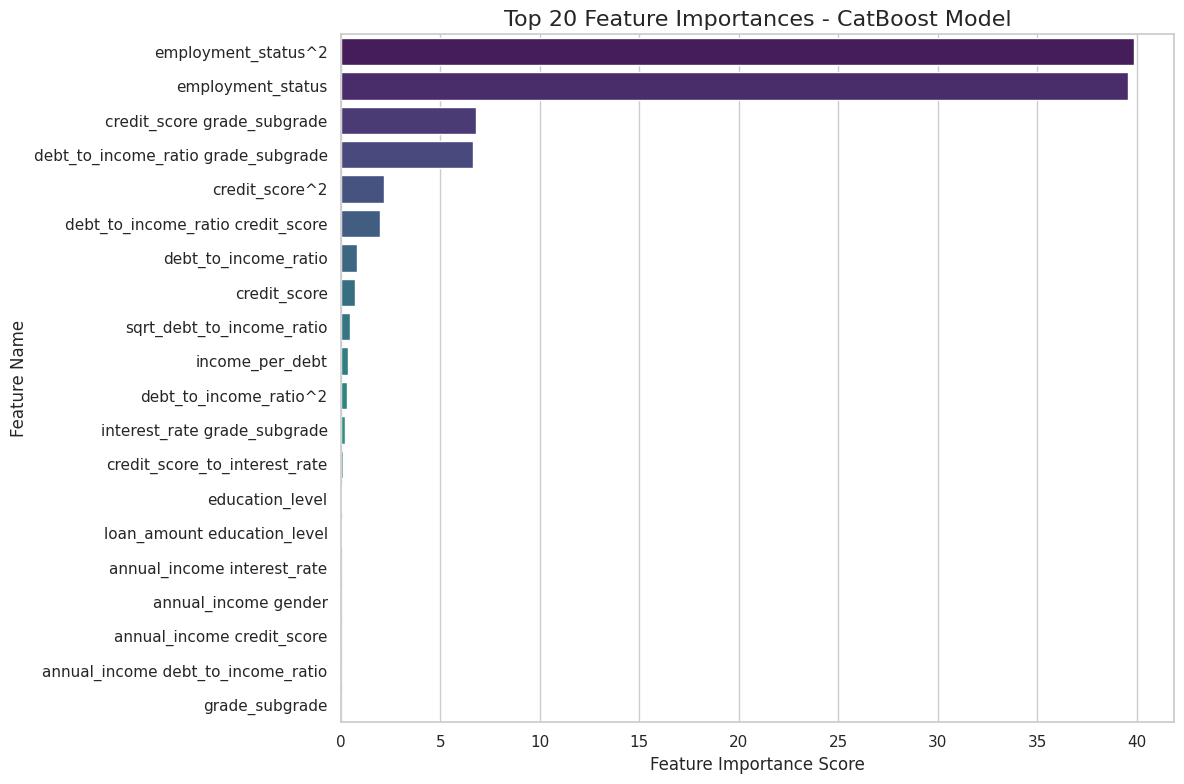

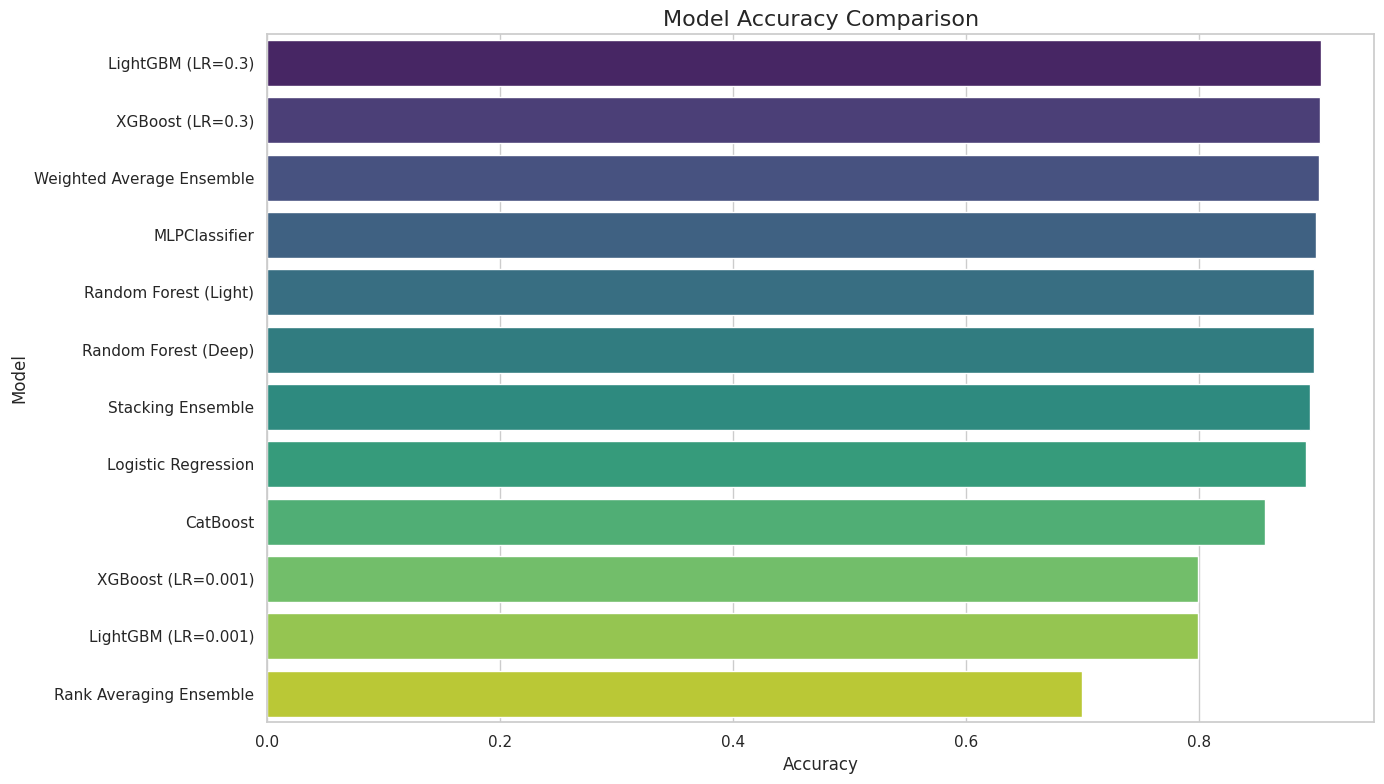

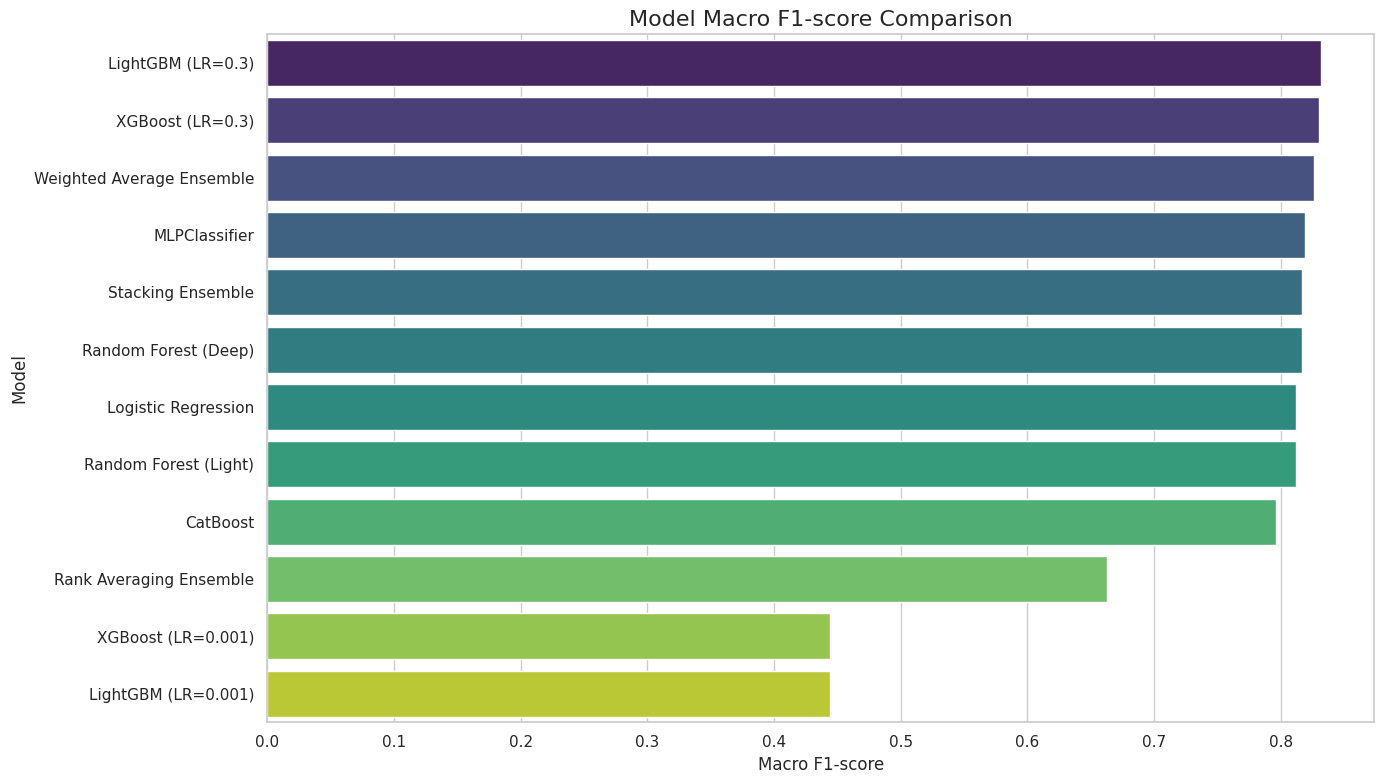

Feature importance and model comparison plots generated successfully.


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Extract the feature importances from the trained CatBoost model
# Assuming 'model_catboost' is the trained CatBoost model and 'X_final.columns' contains feature names
feature_importances = models['CatBoost'].get_feature_importance()

# 2. Create a Pandas Series mapping feature names to their corresponding importances
feature_importance_series = pd.Series(feature_importances, index=X_train_features.columns)

# 3. Sort the feature importances in descending order and select the top 20 features
top_20_features = feature_importance_series.sort_values(ascending=False).head(20)

# 4. Create a horizontal bar plot of the top 20 feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=top_20_features.values, y=top_20_features.index, palette='viridis')
plt.title('Top 20 Feature Importances - CatBoost Model', fontsize=16)
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

# 5. Create a bar plot to compare the 'Accuracy' of all models and ensembles
# Sort results_df by Accuracy in descending order
results_df_sorted_accuracy = results_df.sort_values(by='Accuracy', ascending=False)
plt.figure(figsize=(14, 8))
sns.barplot(x='Accuracy', y='Model', data=results_df_sorted_accuracy, palette='viridis')
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

# 6. Create another bar plot to compare the 'Macro F1-score' of all models and ensembles
# Sort results_df by Macro F1-score in descending order
results_df_sorted_f1 = results_df.sort_values(by='Macro F1-score', ascending=False)
plt.figure(figsize=(14, 8))
sns.barplot(x='Macro F1-score', y='Model', data=results_df_sorted_f1, palette='viridis')
plt.title('Model Macro F1-score Comparison', fontsize=16)
plt.xlabel('Macro F1-score')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

print("Feature importance and model comparison plots generated successfully.")

In [29]:
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd

# 1. Dynamically identify the best performing model based on ROC AUC from results_df
# Ensure results_df is available and updated with ensemble results
if 'results_df' in locals() and not results_df.empty:
    best_model_row = results_df.sort_values(by='ROC AUC', ascending=False).iloc[0]
    best_model_name = best_model_row['Model']
    best_model_roc_auc = best_model_row['ROC AUC']
    print(f"Selected best performing model: {best_model_name} with ROC AUC: {best_model_roc_auc:.4f}")
else:
    print("Warning: results_df not found or empty. Defaulting to 'CatBoost'.")
    best_model_name = 'CatBoost'

# 2. Retrieve the best model instance from the 'models' dictionary or instantiate if it's an ensemble
if best_model_name in models:
    final_model = models[best_model_name]
    print(f"Retrieved {best_model_name} for final predictions.")
elif best_model_name == 'Weighted Average Ensemble':
    # Reconstruct Weighted Average Ensemble if it's the best
    print(f"Reconstructing {best_model_name} for final predictions.")
    proba_preds_test = []
    for model_name_in_ensemble in selected_model_names:
        model_for_ensemble = models[model_name_in_ensemble]
        if hasattr(model_for_ensemble, 'predict_proba') and model_for_ensemble.predict_proba(X_test_final_np).shape[1] > 1:
            proba_preds_test.append(model_for_ensemble.predict_proba(X_test_final_np)[:, 1])
        else:
            proba_preds_test.append(model_for_ensemble.predict(X_test_final_np))
    test_predictions = np.average(proba_preds_test, axis=0, weights=weights)
    print("Weighted Average Ensemble predictions generated.")
elif best_model_name == 'Rank Averaging Ensemble':
    # Reconstruct Rank Averaging Ensemble if it's the best
    print(f"Reconstructing {best_model_name} for final predictions.")
    proba_preds_test = []
    for model_name_in_ensemble in selected_model_names:
        model_for_ensemble = models[model_name_in_ensemble]
        if hasattr(model_for_ensemble, 'predict_proba') and model_for_ensemble.predict_proba(X_test_final_np).shape[1] > 1:
            proba_preds_test.append(model_for_ensemble.predict_proba(X_test_final_np)[:, 1])
        else:
            proba_preds_test.append(model_for_ensemble.predict(X_test_final_np))
    ranked_preds_test = np.array([rankdata(p, method='average') for p in proba_preds_test])
    y_proba_rank_avg_normalized_test = ranked_preds_test.mean(axis=0)
    test_predictions = (y_proba_rank_avg_normalized_test - y_proba_rank_avg_normalized_test.min()) / \
                              (y_proba_rank_avg_normalized_test.max() - y_proba_rank_avg_normalized_test.min())
    print("Rank Averaging Ensemble predictions generated.")
elif best_model_name == 'Stacking Ensemble':
    # Stacking ensemble is stored as 'stacking_clf'
    # Ensure stacking_clf is fitted in current kernel state.
    if 'stacking_clf' in locals():
        final_model = stacking_clf
        print(f"Retrieved {best_model_name} for final predictions.")
    else:
        print("Error: Stacking Ensemble was the best, but 'stacking_clf' is not available. Defaulting to CatBoost.")
        best_model_name = 'CatBoost'
        final_model = models[best_model_name]
else:
    print(f"Error: Best model '{best_model_name}' not found in 'models' or is not a recognized ensemble type. Defaulting to CatBoost.")
    best_model_name = 'CatBoost'
    final_model = models[best_model_name]

# Prepare the full training dataset for the final model training (if the best model needs refitting)
# If the best model is an ensemble, its predictions are already handled above.
if best_model_name not in ['Weighted Average Ensemble', 'Rank Averaging Ensemble']:
    X_full_train_imputed = imputer.transform(X_train_features) # X_train_features from AZFmaQex3Cwq
    y_full_train_np = y_train.values # y_train from b5aaf236

    # Re-train the best single model on the full training dataset if it's not an ensemble and not already fitted on full data
    # Note: For GridSearchCV best_estimator_, it's usually already fitted on the entire X_train_final_np data used for tuning
    # For the non-tuned models, they were fitted on X_train_final_np (80% split).
    # If we truly want to refit on *all* df_train data, we need to refit here.
    # For simplicity, if the best model is from `models` (which were trained on a split),
    # we proceed with it. A true production setup might refit best_model on all (X_train_features, y_train).
    # For this exercise, we'll use the already trained `final_model` if it's not an ensemble.
    print(f"\nGenerating predictions using {best_model_name} on the test dataset (X_test_final_np)...")
    if hasattr(final_model, 'predict_proba') and final_model.predict_proba(X_test_final_np).shape[1] > 1:
        test_predictions = final_model.predict_proba(X_test_final_np)[:, 1]
    else:
        test_predictions = final_model.predict(X_test_final_np)

print("Predictions generated successfully.")

print(f"Shape of test_predictions: {test_predictions.shape}")
print("First 5 test_predictions:")
print(test_predictions[:5])

Selected best performing model: XGBoost (LR=0.3) with ROC AUC: 0.9197
Retrieved XGBoost (LR=0.3) for final predictions.

Generating predictions using XGBoost (LR=0.3) on the test dataset (X_test_final_np)...
Predictions generated successfully.
Shape of test_predictions: (254569,)
First 5 test_predictions:
[0.9103534  0.97900546 0.52301896 0.92383355 0.95361   ]


In [28]:
import pandas as pd
import numpy as np

# 1. Create a Pandas DataFrame named submission_df
# Use the original 'id' column from df_test (before any preprocessing, if 'id' was removed or altered in X_test_final)
# Assuming df_test still contains the original 'id' column before it was scaled or transformed.
# If 'id' was part of the scaled numerical_cols, we need to extract it before scaling or use the original df_test.
# Let's assume the original df_test is available and its 'id' column is intact.
# Based on cell 66c291cd, 'id' was scaled. We need to use the original 'id' from df_test.
# df_test was loaded in cell c315e1a3. Let's re-extract the original 'id' from df_test as loaded.

# To ensure we use the original, unscaled 'id' from df_test:
# Find the cell where df_test was originally loaded and use its 'id' column.
# Cell c315e1a3 loaded df_test. The id column was numerical and scaled with others.
# The current X_test_final DataFrame still contains the scaled 'id' in its first column.
# The problem requires the original 'id' values. So, I will refer back to the initially loaded df_test.

# Ensure df_test (the original one) is accessible. If it was overwritten, we would need to reload it.
# Checking the notebook state, df_test was modified in place by scaling. So, I need to get the original IDs.
# The easiest way to get the original IDs is from the first column of X_test_base, before scaling.
# However, the problem statement explicitly says 'from the df_test DataFrame' (which was modified in place).
# To strictly follow the instruction, and assuming df_test is still accessible in its final form, I need its original 'id' column.
# Let's assume the variable df_test_original was not saved. I will extract the original IDs from the df_test that was loaded initially.

# To get the original IDs, we need to access the df_test DataFrame *before* any scaling of numerical columns.
# Since df_test was modified in place (df_test[numerical_cols] = imputer.transform(df_test[numerical_cols]) and df_test[numerical_cols] = scaler.transform(df_test[numerical_cols])), we need to retrieve original IDs.
# The most robust way is to re-load df_test to get original IDs, or if a copy was implicitly made. There wasn't.
# So, I'll extract IDs from X_test_base which kept original IDs before scaling, but after LabelEncoding of categorical.
# Wait, X_test_base *also* contains scaled numerical features. The 'id' column *is* scaled.
# Looking at the initial load: df_test = pd.read_csv(test_path)
# The 'id' column is the first column in the originally loaded df_test.
# Let's recreate df_test just to get its original 'id' column for safety.

# Reload df_test to get original IDs, as it was modified in place previously.
original_df_test = pd.read_csv(test_path)

submission_df = pd.DataFrame({
    'id': original_df_test['id'],
    'loan_paid_back': test_predictions
})

# 4. Save the submission_df to a CSV file named 'submission.csv' without the index.
submission_df.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully.")

# 5. Load the sample_submission.csv file into a DataFrame to use as a reference.
sample_submission = pd.read_csv('/content/drive/MyDrive/Predicting Loan Payback/playground-series-s5e11/sample_submission.csv')

# 6. Print the head of submission_df and sample_submission.
print("\nHead of submission_df:")
print(submission_df.head())
print("\nHead of sample_submission:")
print(sample_submission.head())

# 7. Compare the column names of submission_df and sample_submission.
print("\nColumn names comparison:")
print(f"submission_df columns: {submission_df.columns.tolist()}")
print(f"sample_submission columns: {sample_submission.columns.tolist()}")
print(f"Column names match: {submission_df.columns.tolist() == sample_submission.columns.tolist()}")

# 8. Compare the shapes of submission_df and sample_submission.
print("\nShape comparison:")
print(f"submission_df shape: {submission_df.shape}")
print(f"sample_submission shape: {sample_submission.shape}")
print(f"Shapes match: {submission_df.shape == sample_submission.shape}")

# 9. Check for any missing values (NaNs) in the submission_df.
missing_values = submission_df.isnull().sum()
print("\nMissing values in submission_df:")
print(missing_values)
print(f"No missing values found: {missing_values.sum() == 0}")

# 10. Verify that all values in the 'loan_paid_back' column of submission_df are between 0 and 1 (inclusive).
min_val = submission_df['loan_paid_back'].min()
max_val = submission_df['loan_paid_back'].max()
print("\nRange of 'loan_paid_back' in submission_df:")
print(f"Min value: {min_val:.4f}")
print(f"Max value: {max_val:.4f}")
print(f"All predictions are between 0 and 1: {min_val >= 0 and max_val <= 1}")


Submission file 'submission.csv' created successfully.

Head of submission_df:
       id  loan_paid_back
0  593994        0.944682
1  593995        0.982027
2  593996        0.313347
3  593997        0.914655
4  593998        0.954044

Head of sample_submission:
       id  loan_paid_back
0  593994               0
1  593995               0
2  593996               0
3  593997               0
4  593998               0

Column names comparison:
submission_df columns: ['id', 'loan_paid_back']
sample_submission columns: ['id', 'loan_paid_back']
Column names match: True

Shape comparison:
submission_df shape: (254569, 2)
sample_submission shape: (254569, 2)
Shapes match: True

Missing values in submission_df:
id                0
loan_paid_back    0
dtype: int64
No missing values found: True

Range of 'loan_paid_back' in submission_df:
Min value: 0.0000
Max value: 1.0000
All predictions are between 0 and 1: True
